In [1]:
import pandas as pd
import numpy as np

import nltk
import spacy
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.collocations import *

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.dummy import DummyClassifier 
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import seaborn as sns
import matplotlib.cm as cm

from gensim.models import Word2Vec, Doc2Vec, TfidfModel, CoherenceModel, AuthorTopicModel
from gensim.models.word2vec import FAST_VERSION
from gensim.models.doc2vec import TaggedDocument
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases
from gensim.test.utils import datapath, temporary_file
from gensim.models import AuthorTopicModel

import time 
import multiprocessing
import string
import random
import re
import json
import sys
import pickle

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense, Activation
from keras.utils import to_categorical

import requests
from bs4 import BeautifulSoup as bs
from lxml import html
import csv
from os import mkdir
from os.path import exists, join

from selenium import webdriver

nlp = spacy.load('en_core_web_sm')
stopwords = stopwords.words("english")
plt.style.use('../themes/rose-pine-dawn.mplstyle')

## 0 - Creation of the Dataset

In order to gather the data, we initially scraped Wikipedia to download the names, tickers and sectors of all the companies listed in S&P500.

In [2]:
from bs4 import BeautifulSoup

datadir = join('..', 'data')
if not exists(datadir):
    mkdir(datadir)
    
URL = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

page = requests.get(URL)

soup = BeautifulSoup(page.content, 'html.parser')

table = soup.find("table", { "class" : "wikitable sortable" })

# Retrieve the values in the table
records = []
rows = table.findAll('tr')
for row in rows:
    fields = row.findAll('td')
    if fields:
        symbol = fields[0].text.replace('\n', '')
        name = fields[1].text
        sector = fields[3].text
        records.append([symbol, name, sector])

header = ['Symbol', 'Name', 'Sector']
writer = csv.writer(open('../data/constituents.csv', 'w'))
writer.writerow(header)
# Sorting ensure easy tracking of modifications
records.sort(key=lambda s: s[1].lower())
writer.writerows(records)   

After gathering the information above, we manually searched for the official LinkedIn pages of all the companies and reported them in another Excel sheet

In [3]:
constituents = pd.read_csv('../data/constituents_csv.csv')

In [4]:
links = pd.read_excel('../data/S&P 500 Links.xlsx') # Excel table we created with all the LinkedIn links for our companies
links.head()

,Unnamed: 0,Name,Link
0,0,3M Company,https://www.linkedin.com/company/3m/
1,1,A.O. Smith Corp,https://www.linkedin.com/company/a.-o.-smith-c...
2,2,Abbott Laboratories,https://www.linkedin.com/company/abbott-/
3,3,AbbVie Inc.,https://www.linkedin.com/company/abbvie/
4,4,Accenture plc,https://www.linkedin.com/company/accenture/


Next step was to scrape all the company posts of the last one year (from 18th April 2020 to 18th April 2021) and store them

In [ ]:
#!/usr/bin/env python
# coding: utf-8

#required installs (i.e. pip3 install in terminal): pandas, selenium, bs4

gendata = pd.DataFrame(np.zeros((1,8)),columns=['Date Posted','Media Type','Post Text','Post Likes','Post Comments','Video Views','Media Links','Company'])

counter = 0

for i in range(len(links.Name)):

    print(links.Name[i])

    page = links.Link[i]
    company_name = links.Name[i]

    if counter == 0: # Counter to avoid incurring in access problems 

        try:
            f= open("credentials.txt","r")
            contents = f.read()
            username = contents.replace("=",",").split(",")[1]
            password = contents.replace("=",",").split(",")[3]
        except:
            f= open("credentials.txt","w+")
            username = input('Enter your linkedin username: ')
            password = input('Enter your linkedin password: ')
            f.write("username={}, password={}".format(username,password))
            f.close()


        #access Webriver
        browser = webdriver.Chrome('C:\\Users\\rebec\\Documents\\Drive\\chromedriver.exe') # Insert the path to your selenium webdriver

        #Open login page of LinkedIn
        browser.get('https://www.linkedin.com/login?fromSignIn=true&trk=guest_homepage-basic_nav-header-signin')

        #Enter login info:
        elementID = browser.find_element_by_id('username')
        elementID.send_keys(username)

        elementID = browser.find_element_by_id('password')
        elementID.send_keys(password)
        #Note: replace the keys "username" and "password" with your LinkedIn login info
        elementID.submit()

    # Go to webpage
    browser.get(page + 'posts/')

    # Insert pausing time
    SCROLL_PAUSE_TIME = 1.5

    # Get scroll height
    try:
        last_height = browser.execute_script("return document.body.scrollHeight")
    except:
        time.sleep(30) # This except is added to avoid incurring in a block of the code while trying to access LinkedIn with double verification

    while True:
        # Scroll down to bottom
        browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")

        # Wait to load page
        time.sleep(SCROLL_PAUSE_TIME)

        # Calculate new scroll height and compare with last scroll height
        new_height = browser.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height


    company_page = browser.page_source   

    linkedin_soup = bs(company_page.encode("utf-8"), "html")
    linkedin_soup.prettify()

    containers = linkedin_soup.findAll("div",{"class":"occludable-update ember-view"})
    #container = containers[0].find("div","display-flex feed-shared-actor display-flex feed-shared-actor--with-control-menu ember-view")


    post_dates = []
    post_texts = []
    post_likes = []
    post_comments = []
    video_views = []
    media_links = []
    media_type = []


    for container in containers:

        try:
            posted_date = container.find("span",{"class":"visually-hidden"})
            text_box = container.find("div",{"class":"feed-shared-update-v2__description-wrapper ember-view"})
            text = text_box.find("span",{"dir":"ltr"})
            new_likes = container.findAll("li", {"class":"social-details-social-counts__reactions social-details-social-counts__item"})
            new_comments = container.findAll("li", {"class": "social-details-social-counts__comments social-details-social-counts__item"})


            post_dates.append(posted_date.text.strip())
            post_texts.append(text.text.strip())

            try:
                video_box = container.findAll("div",{"class": "feed-shared-update-v2__content feed-shared-linkedin-video ember-view"})
                video_link = video_box[0].find("video", {"class":"vjs-tech"})
                media_links.append(video_link['src'])
                media_type.append("Video")
            except:
                try:
                    image_box = container.findAll("div",{"class": "feed-shared-image__container"})
                    image_link = image_box[0].find("img", {"class":"ivm-view-attr__img--centered feed-shared-image__image feed-shared-image__image--constrained lazy-image ember-view"})
                    media_links.append(image_link['src'])
                    media_type.append("Image")
                except:
                    try:
                        #mutiple shared images
                        image_box = container.findAll("div",{"class": "feed-shared-image__container"})
                        image_link = image_box[0].find("img", {"class":"ivm-view-attr__img--centered feed-shared-image__image lazy-image ember-view"})
                        media_links.append(image_link['src'])
                        media_type.append("Multiple Images")
                    except:
                        try:
                            article_box = container.findAll("div",{"class": "feed-shared-article__description-container"})
                            article_link = article_box[0].find('a', href=True)
                            media_links.append(article_link['href'])
                            media_type.append("Article")
                        except:
                            try:
                                video_box = container.findAll("div",{"class": "feed-shared-external-video__meta"})          
                                video_link = video_box[0].find('a', href=True)
                                media_links.append(video_link['href'])
                                media_type.append("Youtube Video")   
                            except:
                                try:
                                    poll_box = container.findAll("div",{"class": "feed-shared-update-v2__content overflow-hidden feed-shared-poll ember-view"})
                                    media_links.append("None")
                                    media_type.append("Other: Poll, Shared Post, etc")
                                except:
                                    media_links.append("None")
                                    media_type.append("Unknown")



            #Getting Video Views. (The following three lines prevents class name overlap)
            view_container2 = set(container.findAll("li", {'class':["social-details-social-counts__item"]}))
            view_container1 = set(container.findAll("li", {'class':["social-details-social-counts__reactions","social-details-social-counts__comments social-details-social-counts__item"]}))
            result = view_container2 - view_container1

            view_container = []
            for i in result:
                view_container += i

            try:
                video_views.append(view_container[1].text.strip().replace(' Views',''))

            except:
                video_views.append('N/A')


            try:
                post_likes.append(new_likes[0].text.strip())
            except:
                post_likes.append(0)
                pass

            try:
                post_comments.append(new_comments[0].text.strip())                           
            except:                                                           
                post_comments.append(0)
                pass
        
        except:
            pass
        
    comment_count = []

    for i in post_comments:
        s = str(i).replace('Comment','').replace('s','').replace(' ','')
        comment_count += [s]

    data = {
        "Date Posted": post_dates,
        "Media Type": media_type,
        "Post Text": post_texts,
        "Post Likes": post_likes,
        "Post Comments": comment_count,
        "Video Views": video_views,
        "Media Links": media_links
    }


    df = pd.DataFrame(data)
    df['Company'] = [company_name]*df.shape[0]

    gendata = gendata.append(df) # Append to the original dataframe
    
    counter += 1

In [ ]:
#gendata.to_csv('../data/Table1.csv',index=False) # Turn scraped info into a csv file

In [5]:
documents =  pd.read_csv('../data/Table1.csv') # Excel table we created with all the LinkedIn links for our companies, thanks to the previous scraping code

documents.head()

,Date Posted,Media Type,Post Text,Post Likes,Post Comments,Video Views,Media Links,Company
0,3 days ago,Video,"As a father, knowing his daughter was on the f...",760,8comment,"18,667",https://dms.licdn.com/playlist/C4E05AQF_zEAsSK...,3M Company
1,1 day ago,Video,Madison studied Integrated Science as an under...,186,2comment,"4,626",https://dms.licdn.com/playlist/C4E05AQHpXFtNsi...,3M Company
2,2 days ago,Video,"Machine Operator, Donna, chose to work at 3M b...",225,1comment,"6,637",https://dms.licdn.com/playlist/C4E05AQHKsq2e1u...,3M Company
3,4 days ago,Video,By 2025 our investments in skills training and...,343,1comment,"9,305",https://dms.licdn.com/playlist/C4E05AQHCdyMzTf...,3M Company
4,1 week ago,Image,Tell us you grew up in the '90s without tellin...,536,26comment,NaN,https://media-exp1.licdn.com/dms/image/C4E22AQ...,3M Company


In [6]:
documents.shape # Number of documents

(55642, 8)

In [7]:
scraped = documents.Company.unique() # Understand how many companies had LinkedIn posts available

In [8]:
len(scraped)

464

In [9]:
# Create an additional row to understand which companies have been scraped and which ones not, to be able to re-run the code in case some error occurred

links['Present'] = 0
links.loc[links.Name.isin(scraped), "Present"] = 1

In [10]:
missing = list(links[links.Present == 0].index)

links.iloc[missing] # Identify which companies haven't been scraped

,Unnamed: 0,Name,Link,Present
9,9,Advanced Micro Devices Inc,https://www.linkedin.com/company/almd/about/,0
12,12,Affiliated Managers Group Inc,https://www.linkedin.com/company/affiliated-ma...,0
23,23,"Allergan, Plc",https://www.linkedin.com/company/allergan/,0
27,27,Alphabet Inc Class A,https://www.linkedin.com/company/alphabet-inc/,0
28,28,Alphabet Inc Class C,NaN,0
43,43,Anadarko Petroleum Corp,https://www.linkedin.com/company/anadarko-petr...,0
45,45,Andeavor,https://www.linkedin.com/company/andeavor/,0
51,51,Apple Inc.,https://www.linkedin.com/company/apple/,0
60,60,Automatic Data Processing,https://www.linkedin.com/company/asparity-deci...,0
103,103,Charter Communications,https://www.linkedin.com/company/charter-commu...,0


In [11]:
sel = constituents[['Symbol','Name','Sector']] # Create a sub-selection of the initial Constitutens table to get cleaner and relevant information, such as the ticker and the sector

sel

,Symbol,Name,Sector
0,MMM,3M Company,Industrials
1,AOS,A.O. Smith Corp,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie Inc.,Health Care
4,ACN,Accenture plc,Information Technology
...,...,...,...
500,XYL,Xylem Inc.,Industrials
501,YUM,Yum! Brands Inc,Consumer Discretionary
502,ZBH,Zimmer Biomet Holdings,Health Care
503,ZION,Zions Bancorp,Financials


In [12]:
# Merge the "sub-selection" of the Constituents table with the scraped data, to get towards the final table

new = pd.merge(
    documents,
    sel,
    how="inner",
    left_on="Company",
    right_on="Name",
    left_index=False,
    right_index=False,
    copy=True,
    indicator=False,
    validate=None,
)

new.drop(columns = 'Name', inplace = True)

new.head() # Get a hint of how the final table will look like

,Date Posted,Media Type,Post Text,Post Likes,Post Comments,Video Views,Media Links,Company,Symbol,Sector
0,3 days ago,Video,"As a father, knowing his daughter was on the f...",760,8comment,"18,667",https://dms.licdn.com/playlist/C4E05AQF_zEAsSK...,3M Company,MMM,Industrials
1,1 day ago,Video,Madison studied Integrated Science as an under...,186,2comment,"4,626",https://dms.licdn.com/playlist/C4E05AQHpXFtNsi...,3M Company,MMM,Industrials
2,2 days ago,Video,"Machine Operator, Donna, chose to work at 3M b...",225,1comment,"6,637",https://dms.licdn.com/playlist/C4E05AQHKsq2e1u...,3M Company,MMM,Industrials
3,4 days ago,Video,By 2025 our investments in skills training and...,343,1comment,"9,305",https://dms.licdn.com/playlist/C4E05AQHCdyMzTf...,3M Company,MMM,Industrials
4,1 week ago,Image,Tell us you grew up in the '90s without tellin...,536,26comment,NaN,https://media-exp1.licdn.com/dms/image/C4E22AQ...,3M Company,MMM,Industrials


In [13]:
#new.to_csv('../data/finale.csv',index=False) # Convert this final table into a working table, to then work on that final version to clean the text, select information and so on

In [14]:
posts = pd.read_csv('../data/finale.csv')

On the other hand we have scraped Yahoo Finance to download some financial data that can be used to label our LinkedIn posts. In particular, we scraped:
1. Price
2. PE Ratio
3. PriceSales
4. PriceBook
5. 52 Week High
6. 52 Week Low
7. Dividend Yield
8. EPS
9. Total number of shares

In addition to these, we calculated the Market Capitalization of the firms by multiplying the number of shares by their price (as of 18th April 2021) and subsequently created three categories of firms based on this last value.

In [15]:
pd.options.display.float_format = '{:.0f}'.format

def info_retrieval (symbol):
    
    # STATISTICS
    URL = 'https://finance.yahoo.com/quote/' + symbol + '/key-statistics?p=' + symbol
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    table = soup.find_all("table", { "class" : "W(100%) Bdcl(c)" })

    # Price
    field = soup.find_all('span', {'class':'Trsdu(0.3s) Fw(b) Fz(36px) Mb(-4px) D(ib)'})[0]
    if field:
        price = field.text
    else:
        price = 0
    if table:

        #Valuation Measures table
        records = []
        rows = table[0].findAll('tr')
        if rows:
            for row in rows:
                fields = row.findAll('td')
                if fields:
                    records.append(fields[1].text)

            PE = records[2]
            PriceSales = records[5]
            PriceBook = records[6]
        else:
            PE = 0
            PriceSales = 0
            PriceBook = 0

        # Stock Price History
        records = []
        rows = table[1].findAll('tr')
        if rows:
            for row in rows:
                fields = row.findAll('td')
                if fields:
                    records.append(fields[1].text)

            WeekHigh52 = records[3]
            WeekLow52 = records[4]
            SP500Change = records[2]
        else:
            WeekHigh52 = 0
            WeekLow52 = 0
            SP500Change = 0

        # Dividends & Splits
        records = []
        rows = table[3].findAll('tr')
        if rows:
            for row in rows:
                fields = row.findAll('td')
                if fields:
                    records.append(fields[1].text)

            DividendYield = records[1].replace('%','')
        else:
            DividendYield = 0
    else:
        PE = 0
        PriceSales = 0
        PriceBook = 0
        WeekHigh52 = 0
        WeekLow52 = 0
        SP500Change = 0
        DividendYield = 0
        
    # SUMMARY
    URL = 'https://finance.yahoo.com/quote/' + symbol + '?p=' + symbol + '&.tsrc=fin-srch'
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    table = soup.find_all("table", { "class" : "W(100%)" })
    
    records = []
    rows = table[1].findAll('tr')
    if rows:
        for row in rows:
            fields = row.findAll('td')
            if fields:
                records.append(fields[1].text)

        EPS = records[3]
        PE = records[2]
    else:
        EPS = 0
        PE = 0

    
    # BALANCE SHEET
    URL = 'https://finance.yahoo.com/quote/' + symbol + '/balance-sheet?p=' + symbol
    s = requests.session()
    page = s.get(URL, headers={'Cache-Control': 'no-cache', "Pragma": "no-cache"})
    soup = BeautifulSoup(page.content, 'html.parser')
    features = soup.find_all('div', 'D(tbr) fi-row Bgc($hoverBgColor):h')
    field_name = []
    n_shares = []
    for f in features:
        field_name.append(f.find('div','D(tbc) Ta(start) Pend(15px)--mv2 Pend(10px) Bxz(bb) Py(8px) Bdends(s) Bdbs(s) Bdstarts(s) Bdstartw(1px) Bdbw(1px) Bdendw(1px) Bdc($seperatorColor) Pos(st) Start(0) Bgc($lv2BgColor) fi-row:h_Bgc($hoverBgColor) Pstart(15px)--mv2 Pstart(10px)').text)
        n_shares.append(f.find('div', 'Ta(c) Py(6px) Bxz(bb) BdB Bdc($seperatorColor) Miw(120px) Miw(140px)--pnclg D(tbc)').text)
    df = pd.DataFrame({'Field_name': field_name, 'n_shares': n_shares})
    value = np.array(df[df['Field_name']=='Share Issued']['n_shares'])[0]
    value = re.sub(',', '', value)
    s.cookies.clear()
    
    
    features = [price, PE, PriceSales, PriceBook, WeekHigh52, WeekLow52, DividendYield, EPS, value]
    for i in range (len(features)):
        features[i] = str(features[i]).replace(',','').replace('N/A', '0')
        if features[i] == '':
            features[i] = 0
        features[i] = float(features[i])
    return features

In [ ]:
# It takes a few hours to scrape all the data; please, do not run it!

fin_data = []
symbols = np.array(constituents['Symbol'])
rows_list = []
for symbol in symbols:
    #row = info_retrieval(symbol)
    print(symbol)
    fin_data.append(row)

In [ ]:
fin_data = fin_data.reset_index().drop('index', axis=1)
fin_data.columns = ['Price', 'PE', 'PriceSales', 'PriceBook', 'WeekHigh52', 'WeekLow52', 'DividendYield', 'EPS', 'EBITDA', '#_of_shares']
fin_data['Symbol'] = df['Symbol']
fin_data['Name'] = df['Name']
fin_data['Sector'] = df['Sector']
fin_data = fin_data[['Symbol', 'Name', 'Sector', 'Price', 'PE', 'PriceSales', 'PriceBook', 'WeekHigh52', 'WeekLow52', 'DividendYield', 'EPS', '#_of_shares']]

For our research purpose, we decided to take into account just the market capitalization. However, all the other data we already scraped may be used for further analysis.

In [ ]:
fin_data['Market_cap']= fin_data['#_of_shares'] * fin_data['Price']

In [ ]:
# Store and divide by quantile for the Market Cap, to be used as a label later

quantile_big = w['Market_cap'].quantile(0.66)
quantile_small = w['Market_cap'].quantile(0.33)

fin_data['quantile'] = 0
for i in range(len(w)):
    if fin_data['Market_cap'][i]<quantile_small:
        fin_data['quantile'][i]=0
    elif fin_data['Market_cap'][i]<quantile_big:
        fin_data['quantile'][i]=1
    else:
        fin_data['quantile'][i]=2

In [ ]:
#fin_data.to_csv('../data/Financials_final.csv')

In [16]:
financials = pd.read_csv('../data/Financials_final.csv')

In [17]:
posts['Market_cap'] = 0
posts['Quantile'] = 0
symbols = financials['Symbol']
values = financials['Market_cap']
for i in range(len(financials)):
    l = 0
    while(l!=len(posts)):
        if values[i] == posts['Symbol'][l]:
            posts['Market_cap'][l] = values[i]
        l+=1

In [18]:
#posts.to_excel('../data/delivery_table.xlsx')

In [19]:
df = pd.read_excel('../data/delivery_table.xlsx')
df

,Unnamed: 0,Unnamed: 0.1,Date Posted,Media Type,Post Text,Company,Symbol,Sector,Market_cap,Quantile,No Link,Hashtag,No Strange,Text Cleaned
0,0,0,3 days ago,Video,"As a father, knowing his daughter was on the f...",3M_Company,MMM,Industrials,186427636,2,"As a father, knowing his daughter was on the f...","['PPE', 'ImprovingLives']","As a father, knowing his daughter was on the f...",father know daughter front line make work get ...
1,1,1,1 day ago,Video,Madison studied Integrated Science as an under...,3M_Company,MMM,Industrials,186427636,2,Madison studied Integrated Science as an under...,['LifeWith3M'],Madison studied Integrated Science as an under...,Madison study Integrated Science undergraduate...
2,2,2,2 days ago,Video,"Machine Operator, Donna, chose to work at 3M b...",3M_Company,MMM,Industrials,186427636,2,"Machine Operator, Donna, chose to work at 3M b...",['LifeWith3M'],"Machine Operator, Donna, chose to work at 3M b...",Machine Operator Donna choose work limitless c...
3,3,3,4 days ago,Video,By 2025 our investments in skills training and...,3M_Company,MMM,Industrials,186427636,2,By 2025 our investments in skills training and...,[],By 2025 our investments in skills training and...,investment skill training learn opportunity cr...
4,4,4,1 week ago,Image,Tell us you grew up in the '90s without tellin...,3M_Company,MMM,Industrials,186427636,2,Tell us you grew up in the '90s without tellin...,['TBT'],Tell us you grew up in the '90s without tellin...,tell grow tell grow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53933,53933,53933,1 year ago,Image,This morning we announced our first quarter 20...,Zoetis,ZTS,Health_Care,83037865,2,This morning we announced our first quarter 20...,['earnings'],This morning we announced our first quarter 20...,morning announce first quarter financial resul...
53934,53934,53934,1 year ago,Image,"Because the world depends on animals, whether ...",Zoetis,ZTS,Health_Care,83037865,2,"Because the world depends on animals, whether ...",['covid19'],"Because the world depends on animals, whether ...",world depend animal companionship comfort nutr...
53935,53935,53935,1 year ago,Image,"We're excited to announce Pumpkin, a new pet i...",Zoetis,ZTS,Health_Care,83037865,2,"We're excited to announce Pumpkin, a new pet i...",[],"We're excited to announce Pumpkin, a new pet i...",excited announce Pumpkin insurance agency care...
53936,53936,53936,1 year ago,Image,Veterinary professionals! Do you struggle to f...,Zoetis,ZTS,Health_Care,83037865,2,Veterinary professionals! Do you struggle to f...,"['podcast', 'COVID19']",Veterinary professionals! Do you struggle to f...,veterinary professional struggle find time vet...


At the end of the phase 0, we get to a table which has 53,938 LinkedIn posts and their related capitalization informations.

## 1. Research Question

Starting from a dataset where the single documents are the last year linkedin posts of the S&P500 companies, we aim at investigating firstly whether there exist any significant differences in the communication within firms across sectors and across different magnitudes of capitalization. In the former scenario, we expect to find more interesting results than in the latter; still, we are going to face the subsequent step (i.e. classification) with the dimension which ends up being the most significant. \
For what concerns the classification task, we start by building a predictive model of the target label using a Logistic Regression as the baseline reference. Then, we proceed with the implementation of more algorithms (such as XGBoost and dimensionality reduction) to investigate whether different models provide significantly different performances. \
Together with this, in the last step, we aim at employing the structured perceptron, LSTM and BI-LSTM in keras implementation in order to train a model able to detect the relevant events for every post (which have been manually labeled by us).

## 2. Data, Preprocessing, Annotation, and Analysis (6 pts)

Find a data set for **text classification** and a data set for **structured prediction**. These can be the same.
Kaggle is a good place to start, or the Google data set search. 
The data sets should have **at least 5,000** documents each. **At least 2000 instances** need to be labeled. 

If there is no label available, you can annotate your own and get up to **2 bonus points**, depending on the amount and complexity of the annotation.

Split each data set into dedicated training, development, and test sets (if they do not include these already)!
Briefly (max. 100 words!) describe the content and type of the data set, and what you are planning to look at.

Preprocess the data and explain (max. 200 words) which preprocessing steps you chose and why, and give statistics of the number of documents, types, and tokens, before and after preprocessing.

We derived our dataset as previously mentioned in section 0. Then, we started preprocessing the data. \
We opt for the collection of all the relevant pre-processing steps needed into a single function, called 'clean'. After having implemented it, we store the cleaned text into a new column called 'Text Cleaned'. Together with this, as you will see during the section, we provide some statistics about the number and the counter of tokens. Then, we implement a graphical representation of the most frequent tokens in our context, after having exluded those that are not relevant for us.

We start by importing 'delivery_table.xlsx', which is our final table. \
In particular, it is composed by 12 columns, some of which are the original ones that we decide to use ('Post Text', 'Company', 'Symbol' and 'Sector'); others are the original ones that we include in order to be fully comprehensive about the explanation of what our dataset is about, but that we do not employ ('Media Type' and 'Date Posted'). Finally, we also have some columns that are improvements and/or extensions of the original ones. In particular, 'No Link', 'Hashtag', 'No Strange' and 'Text Cleaned' have been created with the code you will see in the next boxes. Instead, 'Market_cap' and 'Quantile' (0 for the less capitalized firms, 1 for the medium capitalized and 2 for the largest) have been added from the table deriving from the previous scraping step.

In [20]:
df = pd.read_excel('../data/delivery_table.xlsx')

df.dropna(axis = 0, inplace=True) # Drop null instances

In [21]:
# Function to remove the web links and add a column called NoLink with no links

pattern=r'(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))'

fin = []

for text in df['Post Text']:
    match = re.findall(pattern, text)
    for m in match:
        url = m[0]
        text = text.replace(url, '')
    fin.append(text)
    
df['No Link'] = fin

In [22]:
# Function to store hashtags and store them in a column called Hashtag

pattern = r"#(\w+)"

up = []

for text in df['Post Text']:
    match = re.findall(pattern, text)
    up.append(match)
    
df['Hashtag'] = up

In [23]:
# Function to remove all the non-alphanumeric characters and some other character

regex = re.compile('[^a-zA-Z0-9,\.!?\'\s]')

new = []

for text in df['No Link']:
    nuevo = regex.sub('', text)
    new.append(nuevo)
    
df['No Strange'] = new

In [24]:
# Make sure cleaned posts are strings

documents = df['Post Text'].apply(str).tolist()                   
documents_tok = df['No Strange'].apply(str).tolist()

In [25]:
print('We have', len(documents_tok), 'documents')
len(documents_tok) == len(documents) 

#As expected, the two columns have the same dimension. In fact, at this stage no real preprocessing word by word has been implemented.

We have 53931 documents


True

In [26]:
#This process will take around 9 minutes.
#We want to provide some statistics about the number of tokens in our dataframe which are Nouns, Verbs, Adjectives, Adverbs or proper nouns.

tokens = [token.text for sentence in documents_tok for token in nlp(sentence) if token.pos_ in ('NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN')]

In [27]:
#Lowercase all the tokens

tokenss = []
for i in tokens:
    tok = i.lower()
    tokenss.append(tok)

In [28]:
print('Length of tokens at this step:', len(tokenss))
print()
print(Counter(tokenss))

Length of tokens at this step: 1486679

Counter({'more': 19943, 'learn': 11569, 'how': 11366, 'new': 7909, 'here': 7034, 'team': 6218, 'help': 6086, 'work': 5470, 'today': 5406, 'year': 5251, 'business': 4830, 'read': 4768, 'be': 4712, 'world': 4470, 'join': 4433, 'support': 4086, 'women': 3971, 'employees': 3936, 'day': 3916, 'global': 3909, "'re": 3906, 'proud': 3749, 'people': 3679, 'health': 3661, 'now': 3478, 'have': 3421, 'company': 3381, 'community': 3285, 'technology': 3271, 'communities': 3258, 'covid19': 3247, 'time': 3222, 'future': 3125, 'make': 3077, 'customers': 2971, 'virtual': 2945, 'see': 2913, 'pandemic': 2902, 'energy': 2862, 'part': 2846, 'when': 2753, 'industry': 2748, 'data': 2650, 'working': 2594, 'solutions': 2587, 'first': 2577, 'program': 2547, 'president': 2490, 'ceo': 2484, 'career': 2438, 'care': 2388, 'experience': 2359, 'need': 2358, 'diversity': 2353, 'most': 2327, 'digital': 2272, 'best': 2255, 'years': 2200, 'find': 2177, 'get': 2162, 'together': 2162,

In [29]:
#Removing punctuation marks:

words_no_punc = []

for w in tokenss:
    if w.isalpha():
        words_no_punc.append(w.lower())

#Removing stopwords:

clean_words = []

for w in words_no_punc:
    if w not in stopwords:
        clean_words.append(w)

In [30]:
print('The length of tokens is now:', len(clean_words))

The length of tokens is now: 1368305


In [31]:
#However, we are not interested in words with less than 3 characters

words = [x for x in clean_words if len(x) > 3]

print('The length of tokens is now:', len(words))

The length of tokens is now: 1286740


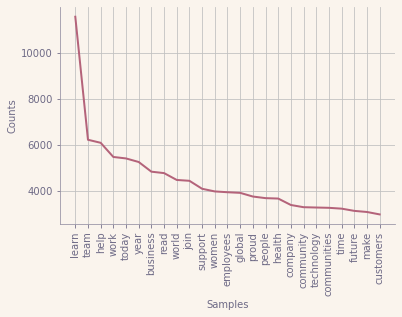

In [32]:
#Frequency distribution of the 25 most common useful words:
fdist = FreqDist(words)
fdist.plot(25)

#What can be noted here is that, even after the preprocessing steps, the distribution of words resembles a Zipf's one.

In [33]:
def clean(text):
    return ' '.join([token.lemma_  #Lemmatization
            for token in nlp(text)
            if (token.pos_ in {'NOUN', 'ADJ', 'ADV', 'VERB'}) & #We don't want all the POS
             (token.lemma_ not in stopwords) &       
             (len(token)>3) &     #We don't want too short words
             (token.lemma_ not in {'more', 'here', 'join', 'click', 'work', 'learn', 'year', 'tell',
                                  'multifamilyrealestate', 'propertymanagement', 'apply', 'livestock',
                                  'help', 'make', 'today', 'read'})]) 

#As you may note, some lemmas were excluded manually, after some trials, in order to get meaningful clusters.
#In fact, some words are extensively employed

In [34]:
#df['Text Cleaned'] = df['No Strange'].apply(clean)  #Adding a column, cleaned, to our df

In [35]:
#df.to_excel('../data/delivery_table.xlsx')

During the preprocessing, we have collected hashtags and created two columns in which we have reported the posts without the links and the posts without any strange non-alphanumeric character.

Finally, we applied the clean function to the 'No Strange' column in order to:
1. Lemmatize
2. Remove stopwords
3. Remove words shorter than 3 characters
4. Remove some words that in the Author Topic Model were creating some mess

We finish with **53,931** documents.





Provide some basic analysis of the training data with any of the following analysis methods (justify your choices):

1. Topic modeling with LDA. Justify your choice of number of topics!
2. Word embeddings 
3. Document embeddings: visualize these and show a clustering

## AUTHOR TOPIC MODELS

We propose two **author topic models** as part of our pre-analysis step in order to determine whether we can see differences within the communication of companies belonging to different sectors and/or characterized by significantly different levels of capitalization.

We start by proposing the intended model on the 'Sector' dimension. We will proceed later on with the second one.

In [44]:
df = pd.read_excel('../data/delivery_table.xlsx')

In [45]:
df = df[df['Text Cleaned'].notna()]

author2doc = defaultdict(list)
target_category = 'Sector'  

for i, Sector in enumerate(df[target_category]):
    author2doc[Sector].append(i)

In [46]:
instances = df['Text Cleaned'].apply(str.split).tolist()
print("Working on creating dictionary, I am fast, keep calm man", flush=True)

phrases = Phrases(instances, min_count=1, threshold=1)
instances_colloc = phrases[instances]

dictionary = Dictionary(instances_colloc)

dictionary.filter_extremes(no_below=1, no_above=0.3) #get rid of some words
print(dictionary, flush=True)

Working on creating dictionary, I am fast, keep calm man
Dictionary(100000 unique tokens: ['daughter', 'father', 'front_line', 'get', 'hospital']...)


In [47]:
print("Translating corpus to IDs, no rush please", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]

tfidfmodel = TfidfModel(ldacorpus)

model_corpus = tfidfmodel[ldacorpus]

Translating corpus to IDs, no rush please


In [40]:
#To find the best number of topics, we run a CoherenceModel with different evaluation scores on a subset of the data.
#Please note that it takes around 30 sec for every value in the range belonging to the for loop

coherence_values = []
author_model_list = []

dev_size = 22000

dev_author2doc = {key: [idx for idx in value if idx < dev_size] for key, value in author2doc.items()}

for num_topics in range(3, 12):
    author_model = AuthorTopicModel(corpus=list(ldacorpus[:dev_size]),  author2doc=dev_author2doc, 
                                    id2word=dictionary, num_topics=num_topics,
                                    alpha=0.6, #the result of some trials
                                    random_state=42) #as we did from the beginning
    
    coherencemodel_umass = CoherenceModel(model=author_model, 
                                          texts=instances[:dev_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=author_model, 
                                       texts=instances[:dev_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

3 -4.622762681800747 0.32042142647796434
4 -5.8838286208563915 0.3972229079190423
5 -6.640565809889895 0.3982480122143932
6 -6.25170710615773 0.4036430046621761
7 -8.89939469413427 0.4479707001576872
8 -8.601454078284966 0.4629596722740411
9 -8.305010296712538 0.4354595754967949
10 -9.98628594819976 0.4630014278550937
11 -10.513016074848586 0.4743109569206473


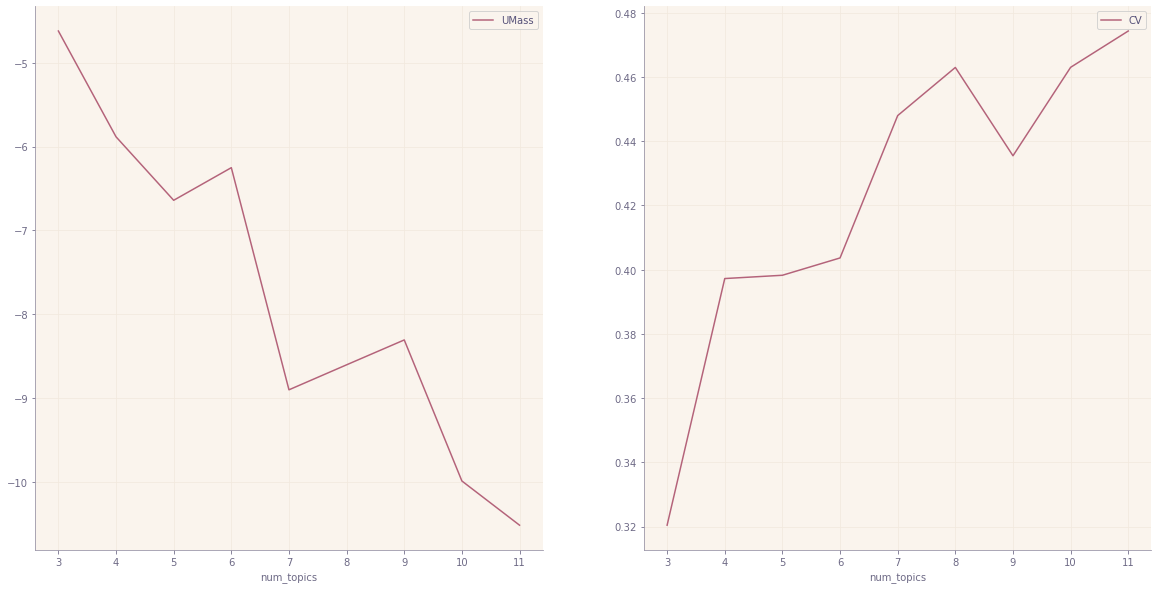

In [41]:
#Graphical representation of UMass and CV scores. 

%matplotlib inline
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(3,12));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(3,12));

In [48]:
#It takes around 4 min

n_topics_author = 8 #We choose 8 as it is a local maximum for the CV score

#We find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

author_model = AuthorTopicModel(corpus=list(ldacorpus), author2doc=author2doc, id2word=dictionary, num_topics=n_topics_author,
                                passes=num_passes, chunksize=chunk_size, alpha=0.6, random_state=42)

2696.55


In [49]:
topic_sep = re.compile("0\.[0-9]{3}\*") #Getting rid of potential useless formatting, in case it is needed (even if the df column is already cleaned)

author_model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                author_model.print_topics(num_topics=n_topics_author, num_words=5)]


author_descriptors = []
for i, m in sorted(author_model_topics):
    print(i+1, ", ".join(m[:5]))
    author_descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "learn", "solution", "technology", "datum", "webinar"
2 "Verizon", "design", "vzcareer", "Xilinx", "power"
3 "business", "learn", "join", "share", "help"
4 "animal", "learn", "support", "work", "celebrate"
5 "Starbucks", "UltaBeauty", "Beauty", "PSEG", "Veterans"
6 "career", "hire", "multifamilyrealestate", "apply", "propertymanagement"
7 "work", "community", "support", "team", "make"
8 "health", "care", "Zoetis", "covid19", "veterinary"


In [50]:
df['Sector'].unique()    # This is needed for the next step, in order to determine all the target sectors

array(['Industrials', 'Health_Care', 'Information_Technology',
       'Consumer_Discretionary', 'Utilities', 'Financials', 'Materials',
       'Real_Estate', 'Consumer_Staples', 'Energy',
       'Telecommunication_Services'], dtype=object)

In [51]:
author_vecs = {author: {author_descriptors[t]: 0.0
                         for t in range(author_model.num_topics)}
              for author in author_model.id2author.values()}

for author in author_model.id2author.values():
    for (t, v) in author_model.get_author_topics(author):
        author_vecs[author][author_descriptors[t]] = v

        
target_sectors = 'Industrials Health_Care Information_Technology Consumer_Discretionary Utilities Financials Materials Real_Estate Consumer_Staples Energy Telecommunication_Services'.split()
for sector in target_sectors:
    print(sector, author_vecs[sector])

Industrials {'learn, solution': 0.2406526550958213, 'Verizon, design': 0.0, 'business, learn': 0.15578713677367984, 'animal, learn': 0.09140532314417481, 'Starbucks, UltaBeauty': 0.019934542266001404, 'career, hire': 0.0, 'work, community': 0.4749195007756482, 'health, care': 0.0}
Health_Care {'learn, solution': 0.024517616318933098, 'Verizon, design': 0.0, 'business, learn': 0.06477531245613495, 'animal, learn': 0.29094878825684356, 'Starbucks, UltaBeauty': 0.0, 'career, hire': 0.0, 'work, community': 0.1647021076626661, 'health, care': 0.4522537541191773}
Information_Technology {'learn, solution': 0.10592780858541628, 'Verizon, design': 0.10524979155466506, 'business, learn': 0.25055568769966835, 'animal, learn': 0.06530489966987736, 'Starbucks, UltaBeauty': 0.0, 'career, hire': 0.0, 'work, community': 0.38980322276247736, 'health, care': 0.070424533782182}
Consumer_Discretionary {'learn, solution': 0.0, 'Verizon, design': 0.0, 'business, learn': 0.17484536748082538, 'animal, learn':

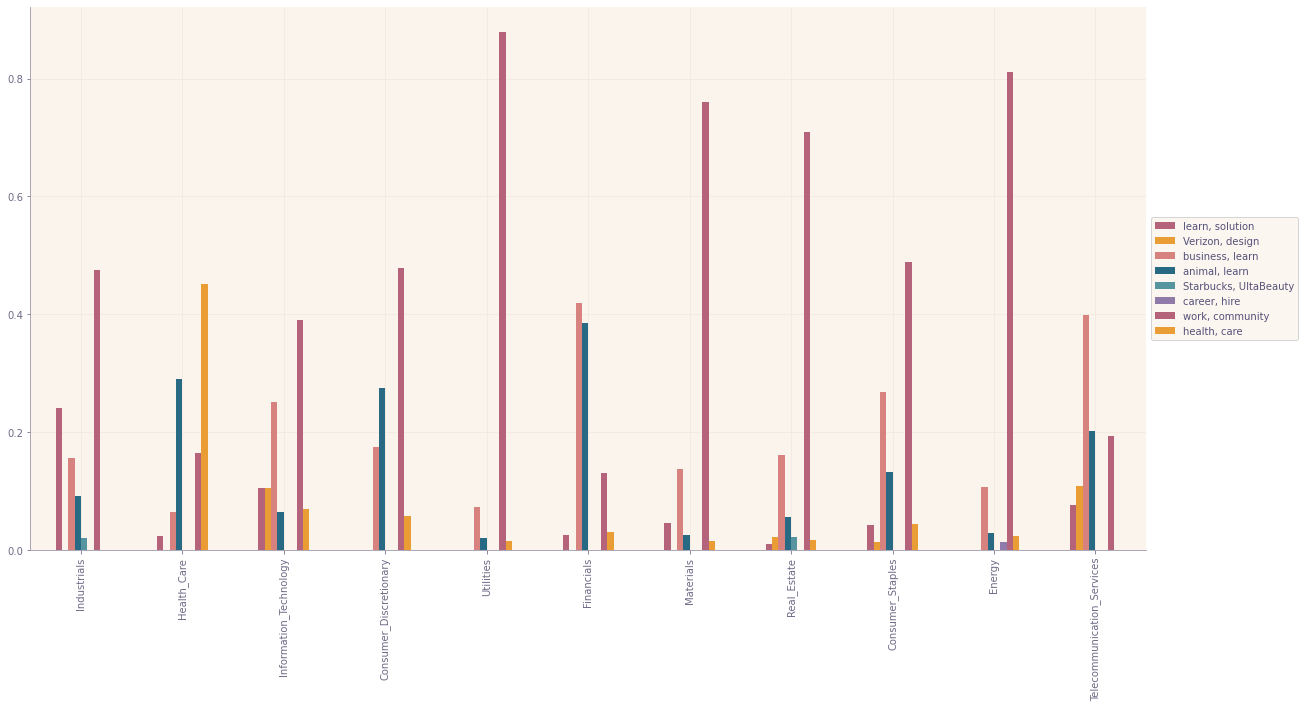

In [52]:
#Graphical representation of the importance of topics by sector

author_df = pd.DataFrame.from_dict(author_vecs)

fig, ax = plt.subplots(figsize=(20,10))
author_df[target_sectors].T.plot.bar(ax=ax)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

Generally speaking we start seeing some interesting elements. As expected, different sectors appear to have some common elements but also some distinctive features. \
In particular, we see a prevalence of the seventh column across all sectors. This appears to make sense in that the relative topic includes words such as "team" and "community" which are common in all fields.  \
The orange column mainly characterizes the Healthcare industry. Within the 5 words, 4 are very typical of that sector, plus the 5th ("Zoetis"), results to be one of the major players. The little presence of this column across all sectors tends to be driven by 'covid19' which, as we know, has become a common topic for everyone. \
"Technology" is evidently the key element on which the height of the first column base its pillars on. In fact, both in the 'industrial' and in the 'IT' sector, clients consider it to be one of the key ingredients for their choices. \
Topics 5 and 6 are not much present. \
The 2nd topic has a difficult interpretation for our previous knowledge. Still, it appears to be mostly connected with the Healthcare sector. \
Finally, the 3rd column is present almost everywhere. This makes sense in that 'business', 'learn', 'share' and 'help' are topics of remarkable importance in every single sector. Still, the peculiar height reached in the Financial sector is probably explainable by the word 'share', which, as we all know, in that specific sector assumes more than just one meaning.

Now, we proceed with the second author topic modelling implementation.

In [53]:
df['Quantile'] = df['Quantile'].apply(str)

In [54]:
author2doc = defaultdict(list)
target_category_1 = 'Quantile'  

for i, quantile in enumerate(df[target_category_1]):
    author2doc[quantile].append(i)

In [55]:
instances_1 = df['Text Cleaned'].apply(str.split).tolist()
print("Again: working on creating this dictionary, I am fast, don't rush", flush=True)

phrases_1 = Phrases(instances_1, min_count=1, threshold=1)
instances_colloc_1 = phrases_1[instances_1]

dictionary_1 = Dictionary(instances_colloc_1)

dictionary_1.filter_extremes(no_below=1, no_above=0.3) #get rid of some words, same parameters as the previous model
print(dictionary_1, flush=True)

Again: working on creating this dictionary, I am fast, don't rush
Dictionary(100000 unique tokens: ['daughter', 'father', 'front_line', 'get', 'hospital']...)


In [56]:
print("Translating corpus to IDs, no rush please", flush=True)
ldacorpus_1 = [dictionary_1.doc2bow(text) for text in instances_1]

tfidfmodel_1 = TfidfModel(ldacorpus_1)

model_corpus_1 = tfidfmodel_1[ldacorpus_1]

Translating corpus to IDs, no rush please


In [57]:
#Again, to find the best number of topics, we run a Coherence Model with different evaluation scores on a subset of the data.
#Please note that it takes around 30 sec for each value in the range belonging to the for loop

coherence_values_1 = []
author_model_list = []

dev_size = 22000

dev_author2doc = {key: [idx for idx in value if idx < dev_size] for key, value in author2doc.items()}

for num_topics in range(3, 12):
    author_model_1 = AuthorTopicModel(corpus=list(ldacorpus_1[:dev_size]),  author2doc=dev_author2doc, 
                                    id2word=dictionary_1, num_topics=num_topics,
                                    alpha=0.6, #the result of some trials
                                    random_state=42) #as I did from the beginning)
    
    coherencemodel_umass_1 = CoherenceModel(model=author_model_1, 
                                          texts=instances_1[:dev_size], 
                                          dictionary=dictionary_1, 
                                          coherence='u_mass')

    coherencemodel_cv_1 = CoherenceModel(model=author_model_1, 
                                       texts=instances_1[:dev_size], 
                                       dictionary=dictionary_1, 
                                       coherence='c_v')

    umass_score_1 = coherencemodel_umass_1.get_coherence()
    cv_score_1 = coherencemodel_cv_1.get_coherence()
    
    print(num_topics, umass_score_1, cv_score_1)
    coherence_values_1.append((num_topics, umass_score_1, cv_score_1))

3 -5.147720754513091 0.33818484911428665
4 -6.264521330985969 0.40555171350149427
5 -6.90047355000967 0.3999802152066046
6 -6.964338043376995 0.3934104093047344
7 -9.105512557937159 0.4632935043262844
8 -8.898683583557492 0.4631169149184753
9 -9.161579687758453 0.45313995081148595
10 -10.868684142709338 0.4923940095382708
11 -11.340401381040817 0.49802855304503346


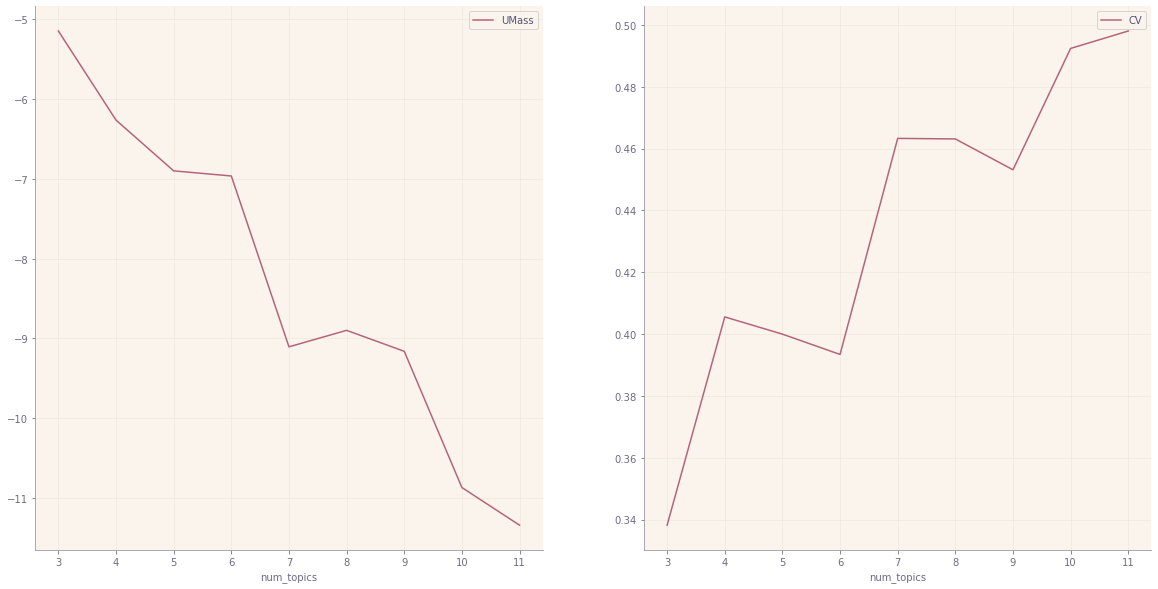

In [58]:
#Graphical representation of UMass and CV scores. 

%matplotlib inline
scores = pd.DataFrame(coherence_values_1, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(3,12));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(3,12));

In [59]:
#It takes around 5 min

n_topics_author = 8                     #We choose 8 as it is a local maximum for UMass

#We find chunksize to make about 200 updates
num_passes = 10
chunk_size_1 = len(model_corpus_1) * num_passes/200
print(chunk_size_1)

author_model_1 = AuthorTopicModel(corpus=list(ldacorpus_1), author2doc=author2doc, id2word=dictionary_1, num_topics=n_topics_author,
                                passes=num_passes, chunksize=chunk_size_1, alpha=0.6, random_state=42)
                                #parameter consistency

2696.55


In [60]:
topic_sep = re.compile("0\.[0-9]{3}\*") #Getting rid of useless formatting, in case it is needed (even if the df column is already cleaned)

author_model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                author_model_1.print_topics(num_topics=n_topics_author, num_words=5)]


author_descriptors = []
for i, m in sorted(author_model_topics):
    print(i+1, ", ".join(m[:5]))
    author_descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "learn", "technology", "solution", "datum", "join"
2 "Verizon", "design", "vzcareer", "Xilinx", "Starbucks"
3 "learn", "business", "share", "join", "work"
4 "animal", "Zoetis", "veterinary", "tune", "nutrition"
5 "veteran", "LGBTQ", "military", "Equality", "Johnson"
6 "devoted", "career", "hire", "multifamilyrealestate", "propertymanagement"
7 "work", "community", "support", "make", "team"
8 "health", "care", "covid19", "disease", "learn"


In [61]:
df['Quantile'].unique()

array(['2', '0', '1'], dtype=object)

In [62]:
author_vecs = {author: {author_descriptors[t]: 0.0
                         for t in range(author_model_1.num_topics)}
              for author in author_model_1.id2author.values()}

for author in author_model_1.id2author.values():
    for (t, v) in author_model_1.get_author_topics(author):
        author_vecs[author][author_descriptors[t]] = v

        
target_quantiles = '0 1 2'.split()
for quantile in target_quantiles:
    print(quantile, author_vecs[quantile])

0 {'learn, technology': 0.05044909083920954, 'Verizon, design': 0.0, 'learn, business': 0.5792575157445001, 'animal, Zoetis': 0.045894452308570505, 'veteran, LGBTQ': 0.010395320952737055, 'devoted, career': 0.0, 'work, community': 0.2632658967802904, 'health, care': 0.04562969507831139}
1 {'learn, technology': 0.23894673667459637, 'Verizon, design': 0.0, 'learn, business': 0.3636093198397061, 'animal, Zoetis': 0.020744200529470402, 'veteran, LGBTQ': 0.025239676622543717, 'devoted, career': 0.0, 'work, community': 0.21354643427332093, 'health, care': 0.1300940310707525}
2 {'learn, technology': 0.027927925790987674, 'Verizon, design': 0.0, 'learn, business': 0.11326922008075624, 'animal, Zoetis': 0.21051444461310642, 'veteran, LGBTQ': 0.0, 'devoted, career': 0.0, 'work, community': 0.22729773084655383, 'health, care': 0.41499827637901215}


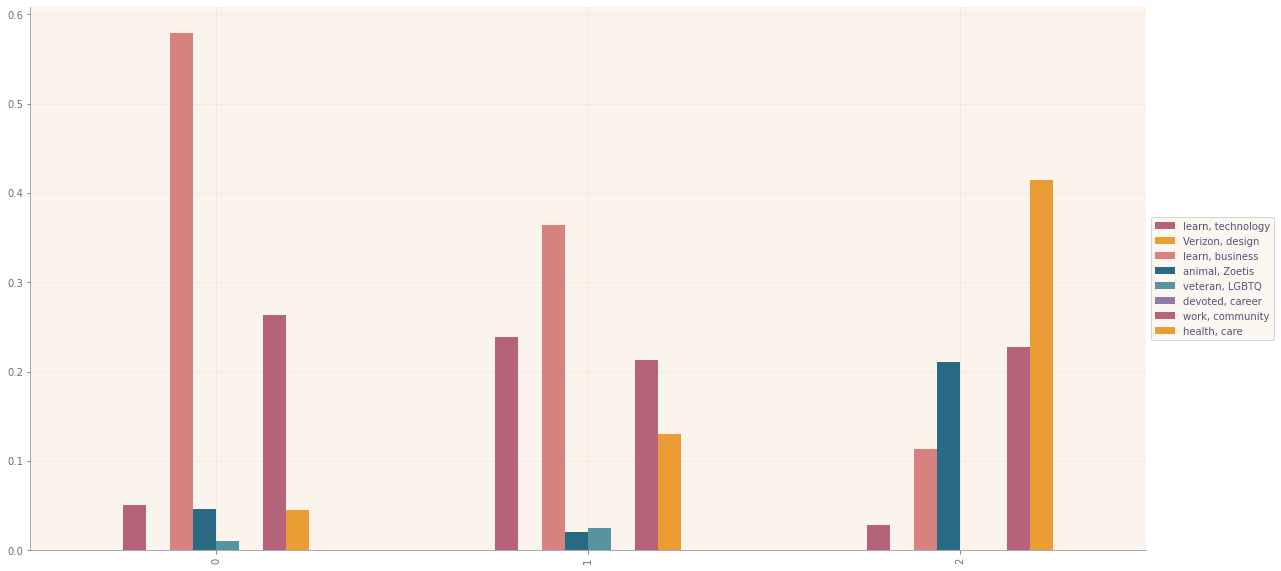

In [63]:
#Graphical representation of the importance of topics by sector

author_df = pd.DataFrame.from_dict(author_vecs)

fig, ax = plt.subplots(figsize=(20,10))
author_df[target_quantiles].T.plot.bar(ax=ax)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

Also in the 'capitalization dimension' some relevant differences must be underlined in the topics that the firms decide to mostly talk about in their linkedin pages.

The most common concepts of "learn", "business", "share", "join" and "work" appear to characterize mostly the smaller firms. Does this make sense? Probably yes; the 'too big to fail' firms maybe prefer to rely on more sophisticated concepts.\
Both the 4th and the 8th columns, mainly devoted to the healthcare sector, appear to dominate the last segment. This is probably due to the fact that, as of today, a lot of the more capitalized firms, belong to the healthcare industry. \
As always, the concepts of 'team' and 'community', represented by the 7th column, are present across all the sectors. \
Finally, topics 2, 5 and 6 seem not to be much relevant in any of the segments. Instead, the 1st topic, probably guided by 'technology', dominates the middle-segment. It is a potentially interesting factor to be further investigated. 

Still, we think that the first model we provide is somewhat more interesting in that it captures much more peculiarities than this second one. For this reason, we proceed in the next step by considering the 'Industry' dimension.

## 4. Prediction (17 pts)


### 4.1 Classification (9 pts)
Build a predictive model of the target label and use appropriate performance metrics. Your predictive analysis needs to involve **all** of the following, summarized in a table:

1. a most-frequent-label baseline (1 pt)
2. a `LogisticRegression()` baseline with default parameters and 2-6 gram character TFIDF features (1 pt)
3. **at least** two more predictive models, including description/justification of the optmization steps taken (6 pts).
4. bootstrap sampling significance tests of the performance difference between your best model and each of the two baselines (1 pts)

NB: Do make sure that the optimization steps are done on the development split and do *not* include the test split! Training on the test set will be graded 0!





In this section, we will be going through various classification algorithms. We will take the Most Frequent Table and the Logistic Regression results as the comparison baselines. 

Apart from the two baselines (Most Frequent and Standard Logistic), we will implement three optimizations:
1. Logistic Regression with Grid Search
2. K-Best
3. Gradient Boosting

The choice of these three is justified step by step.

Finally, we will be conducting two bootstrap sampling significance tests between the Gradient Boosting (our best performing model) and the two baselines' performances.

In [64]:
# First, let's see once again our table
df.head(2)

,Unnamed: 0,Unnamed: 0.1,Date Posted,Media Type,Post Text,Company,Symbol,Sector,Market_cap,Quantile,No Link,Hashtag,No Strange,Text Cleaned
0,0,0,3 days ago,Video,"As a father, knowing his daughter was on the f...",3M_Company,MMM,Industrials,186427636,2,"As a father, knowing his daughter was on the f...","['PPE', 'ImprovingLives']","As a father, knowing his daughter was on the f...",father know daughter front line make work get ...
1,1,1,1 day ago,Video,Madison studied Integrated Science as an under...,3M_Company,MMM,Industrials,186427636,2,Madison studied Integrated Science as an under...,['LifeWith3M'],Madison studied Integrated Science as an under...,Madison study Integrated Science undergraduate...


In [65]:
# PREPARE THE DATASET for Classification Task

df = df.sample(frac=1)[:] # Reshuffle the dataset, keeping the original indexes fixed to be able to re-identify them when needed

# Create a column to be used in the XGBoost with codified labels 

df["body_style_cat"] = 0 # Consumer discretionary
df.loc[df['Sector'] == 'Consumer_Staples','body_style_cat'] = 1
df.loc[df['Sector'] == 'Energy','body_style_cat'] = 2
df.loc[df['Sector'] == 'Financials','body_style_cat'] = 3
df.loc[df['Sector'] == 'Health_Care','body_style_cat'] = 4
df.loc[df['Sector'] == 'Industrials','body_style_cat'] = 5
df.loc[df['Sector'] == 'Information_Technology','body_style_cat'] = 6
df.loc[df['Sector'] == 'Materials','body_style_cat'] = 7
df.loc[df['Sector'] == 'Real_Estate','body_style_cat'] = 8
df.loc[df['Sector'] == 'Telecommunication_Services','body_style_cat'] = 9
df.loc[df['Sector'] == 'Utilities','body_style_cat'] = 10

# Determine the sizes of the train, development and test sets:

N = len(df)
train_size = int(N*0.6)
dev_size = int(N*0.2)
test_size = int(N*0.2)

# Effectively split the data

train = df[:train_size] # TRAIN set
dev = df[train_size: train_size+dev_size] # DEVELOPMENT set
test = df[train_size+dev_size:] # TEST set

print("The sizes of the train, development and test sets are, respectively:",len(train), len(dev), len(test))

The sizes of the train, development and test sets are, respectively: 32358 10786 10787


In [66]:
target = 'Sector' # CHANGE THE TARGET WHEN NEEDED

y_train = train[target] # TRAIN y

y_dev = dev[target] # DEVELOPMENT y

y_test = test[target] # TEST y

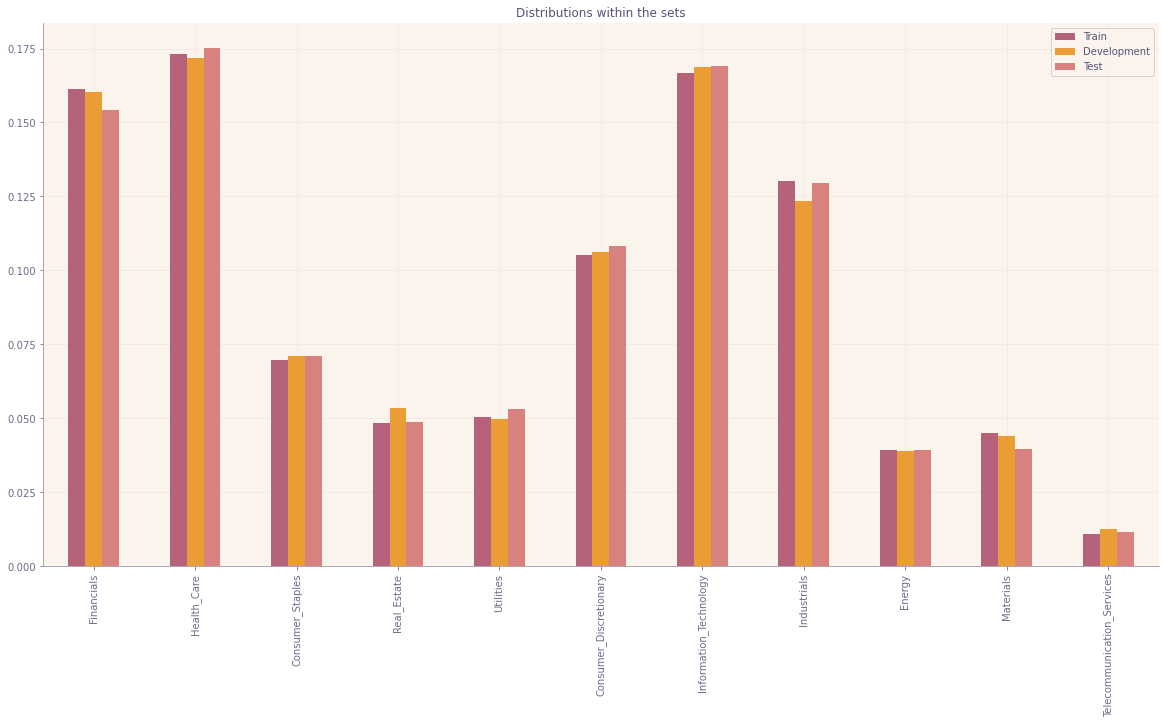

In [67]:
# Plot the frequencies to see if they are balanced

train_split = {k: v/len(y_train) for k, v in Counter(y_train).items()}
development_split = {k: v/len(y_dev) for k, v in Counter(y_dev).items()}
test_split = {k: v/len(y_test) for k, v in Counter(y_test).items()}

trainplot = pd.DataFrame(train_split.values(),index=train_split.keys(),columns=['Train'])

developmentplot = pd.DataFrame(development_split.values(),index=development_split.keys(),columns=['Development'])
testplot = pd.DataFrame(test_split.values(),index=test_split.keys(),columns=['Test'])

dataplot = pd.merge(trainplot, developmentplot, left_index=True, right_index=True)
dataplot = pd.merge(dataplot, testplot, left_index=True, right_index=True)


dataplot.plot(y=["Train", "Development", "Test"], kind="bar",figsize=(20,10),title='Distributions within the sets')

In [68]:
# PREPARE THE DATA WITH A TF-IDF WITH PARAMETERS THAT ARE SUITABLE FOR OUR TASK

vectorizer = TfidfVectorizer(ngram_range=(2,6), 
                             min_df=0.023, # We want sequences that appear enough times
                             max_df=0.30, # But we don't want features that appear in a lot of documents 
                             analyzer='char', # As stated in the lectures, CHARACTER N-GRAMS!
                             sublinear_tf = True, # 1 + log(tf) 
                             lowercase = True, # Convert all characters to lowercase when tokenizing
                            )

X_train = vectorizer.fit_transform(train['Text Cleaned']) # TRAIN set

X_dev = vectorizer.transform(dev['Text Cleaned']) # DEVELOPMENT set

X_test = vectorizer.transform(test['Text Cleaned']) # TEST set 

print('TRAIN:', X_train.shape,'DEVELOPMENT:', X_dev.shape, 'TEST:', X_test.shape)

TRAIN: (32358, 5188) DEVELOPMENT: (10786, 5188) TEST: (10787, 5188)


### (1) BASELINE: Most Frequent Label

We can see that, by using the Most Frequent Label baseline, total accuracy is **17%**. Not much.

In [69]:
most_frequent = DummyClassifier(strategy='most_frequent') # Use the dummy classification for the most frequent class

most_frequent.fit(X_train, y_train) # Fit the model over the TRAIN set

dumb_predictions = most_frequent.predict(X_dev) # DEVELOPMENT set 

print(classification_report(y_dev, dumb_predictions)) # DEVELOPMENT set performance

                            precision    recall  f1-score   support

    Consumer_Discretionary       0.00      0.00      0.00      1146
          Consumer_Staples       0.00      0.00      0.00       765
                    Energy       0.00      0.00      0.00       420
                Financials       0.00      0.00      0.00      1729
               Health_Care       0.17      1.00      0.29      1852
               Industrials       0.00      0.00      0.00      1331
    Information_Technology       0.00      0.00      0.00      1822
                 Materials       0.00      0.00      0.00       473
               Real_Estate       0.00      0.00      0.00       577
Telecommunication_Services       0.00      0.00      0.00       135
                 Utilities       0.00      0.00      0.00       536

                  accuracy                           0.17     10786
                 macro avg       0.02      0.09      0.03     10786
              weighted avg       0.03      0.1

C:\Users\Tiziano\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
names_sectors = list(df.Sector.unique())
names_sectors.sort()
names_sectors

['Consumer_Discretionary',
 'Consumer_Staples',
 'Energy',
 'Financials',
 'Health_Care',
 'Industrials',
 'Information_Technology',
 'Materials',
 'Real_Estate',
 'Telecommunication_Services',
 'Utilities']

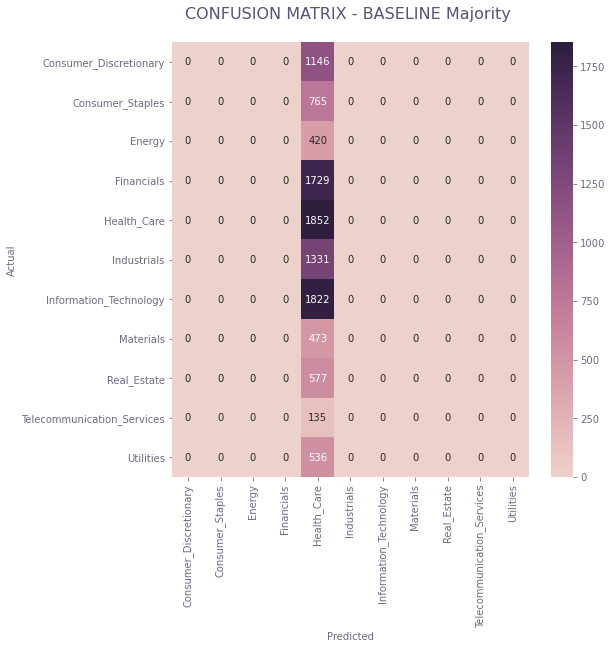

In [71]:
cmap = sns.cubehelix_palette(as_cmap=True)

conf_mat = confusion_matrix(y_dev, dumb_predictions)

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap=cmap, fmt='d',
            xticklabels=names_sectors, 
            yticklabels=names_sectors)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - BASELINE Majority \n", size=16);

### (2) BASELINE: Logistic Regression

Using the Logistic Regression seems to prove useful in our case, even with standard parameters. We reach, this time, a **57%** accuracy.

In [72]:
classifier = LogisticRegression(n_jobs=-1, 
                                multi_class='auto', # Standard, unbalanced inputs
                                solver='lbfgs') 

classifier.fit(X_train, y_train) # Fit the Logistic over the TRAIN set 

predictions = classifier.predict(X_dev) # Predict for the DEVELOPMENT set

print(classification_report(y_dev,predictions))

                            precision    recall  f1-score   support

    Consumer_Discretionary       0.50      0.51      0.50      1146
          Consumer_Staples       0.52      0.38      0.44       765
                    Energy       0.68      0.39      0.49       420
                Financials       0.53      0.67      0.59      1729
               Health_Care       0.65      0.72      0.69      1852
               Industrials       0.50      0.51      0.51      1331
    Information_Technology       0.54      0.65      0.59      1822
                 Materials       0.63      0.37      0.47       473
               Real_Estate       0.82      0.39      0.53       577
Telecommunication_Services       0.91      0.30      0.46       135
                 Utilities       0.69      0.51      0.58       536

                  accuracy                           0.57     10786
                 macro avg       0.63      0.49      0.53     10786
              weighted avg       0.58      0.5

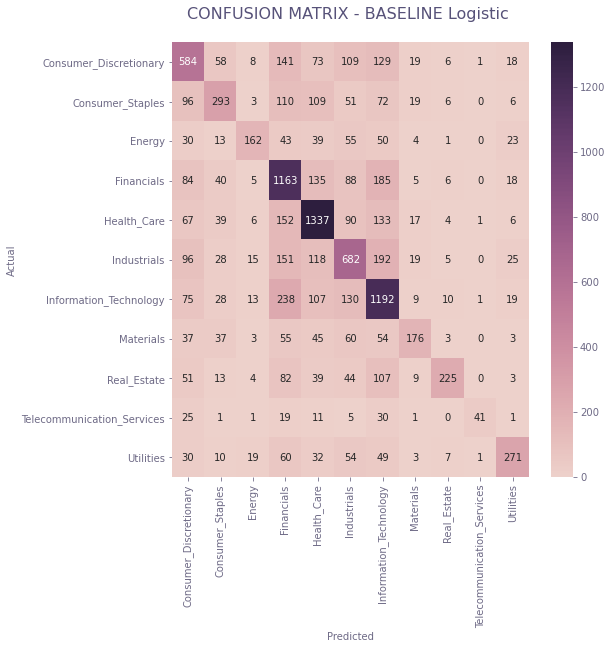

In [73]:
conf_mat = confusion_matrix(y_dev, predictions)

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap=cmap, fmt='d',
            xticklabels=names_sectors, 
            yticklabels=names_sectors)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - BASELINE Logistic \n", size=16);

### (3) FIRST OPTIMIZATION: Logistic Regression with Grid Search

The first optimization step we take is the Logistic Regression with parameters tuned by grid search. The numbers we chose for the grid search originate from several runs for different grids in which we saw that the most likely parameters are the ones stated below here. They are the byproduct of a thought process in which accurate search has been made beforehand.

More specifically, in this case we tune the **C** parameter (inverse of regularization strength), and the **class_weight** parameter (weights associated with classes in the form {class_label: weight} and, if not given, all classes are supposed to have weight one).

As you can see, the *class_weight* parameter doesn't seem to help much when set to "balanced". We have also tried to change the *solver*, the *penalty* and the *tolerance*, but the one we found (here below) seem to have the best parameters for our case. 

In [74]:
# OPTIMIZE the Logistic Regression

base_clf = LogisticRegression(n_jobs=-1)

# Parameters to be optimized, namely the regularization parameter and the class weight 

param_grid = {'C': [50, 25, 5, 2, 0.1, 0.01], # Grid centered at 5 and 2, the most likely parameters
              'class_weight': ['balanced', None]
             }


# OPTIMIZE through CV

search = GridSearchCV(base_clf, # use the classifier defined above
                      param_grid, # use the parameters defined above
                      cv=5, # use 5-fold cross validation
                      scoring = 'f1_micro') # use micro F1 to select best model

search.fit(X_train, y_train) # TRAIN set fitting 

clf_best = search.best_estimator_ # Find best estimators 

print(clf_best.get_params(), search.best_score_)

clf_best.fit(X_train, y_train) # fit this classifier on the entire training data, instead of CV

clf_bestpred = clf_best.predict(X_dev) # Predict for the DEVELOPMENT set

print(classification_report(y_dev,clf_bestpred))

{'C': 5, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': -1, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False} 0.5976575628185387
                            precision    recall  f1-score   support

    Consumer_Discretionary       0.55      0.55      0.55      1146
          Consumer_Staples       0.53      0.46      0.50       765
                    Energy       0.66      0.49      0.56       420
                Financials       0.57      0.68      0.62      1729
               Health_Care       0.68      0.74      0.71      1852
               Industrials       0.54      0.54      0.54      1331
    Information_Technology       0.57      0.65      0.61      1822
                 Materials       0.60      0.45      0.51       473
               Real_Estate       0.76      0.46      0.57       577
Telecommunication_Services 

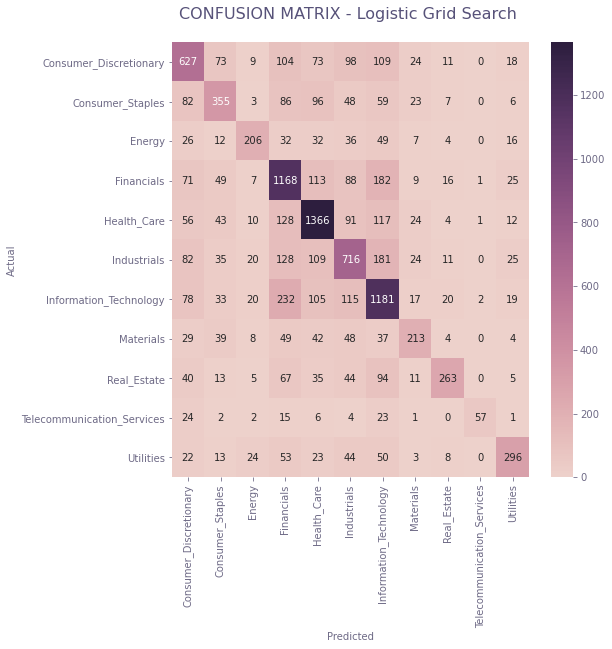

In [75]:
conf_mat = confusion_matrix(y_dev, clf_bestpred)

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap=cmap, fmt='d',
            xticklabels=names_sectors, 
            yticklabels=names_sectors)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Logistic Grid Search \n", size=16);

### (4) SECOND OPTIMIZATION: Less inputs, with K Best

Let's try with K-Best. We start from our tuned Logistic, the one that brought us from 57% accuracy to 60% accuracy because of a change in the regularization strength. We try to reduce the number of inputs. As you will see in this subsection, our model tends to keep most of the features, and for this reason we do not obtain drastic improvements. In any case, the slight improvement can be seen in the last three rows of the report: we get a 60% accuracy as before even with K best, but apparently it helps us get less noise, and we obtain higher *macro avg* and higher *weighted avg*.

We decided not to make use of dimensionality reduction because the extra efforts don't payoff enough. 

In [76]:
# PIPELINE: Setting up the sequence of steps

pipe = Pipeline([
    ('selector', 'passthrough'), # Select features by passthrough
    ('classifier', clf_best) # The Logistic Regression with optimal C (regularization strength)
])

# Selection range of the parameters by Chi2

param_grid = [
    {
        'selector': [SelectKBest(chi2)],
        'selector__k': [5000, 4000, 3000, 1000, 500]  # Starting from the highest, we have 5025 predictors
    },
]

# Fit the model combos

grid = GridSearchCV(pipe, 
                    param_grid=param_grid, 
                    cv=5, 
                    scoring='f1_micro',
                    n_jobs=-1,
                   )

grid.fit(X_train, y_train) # Do the grid search over the TRAIN set

print(grid.best_score_, grid.best_params_['selector'])

selector = grid.best_params_['selector'].fit(X_train, y_train) # Store the best model

X_train_sel = selector.transform(X_train)
X_dev_sel = selector.transform(X_dev)
X_test_sel = selector.transform(X_test)

0.5951853510546913 SelectKBest(k=5000, score_func=<function chi2 at 0x00000203988A88B0>)


In [77]:
# After performing a selection over the K best inputs, we use our tuned model from the previous section (Logistic with C = 5 and unbalanced classes) and train it on our selected parameters

clf_best.fit(X_train_sel, y_train) # TRAIN set, with selected K inputs, for our optimal Logistic

predictions_sel = clf_best.predict(X_dev_sel) # DEVELOPMENT set, same for the train

print(classification_report(y_dev, predictions_sel))

                            precision    recall  f1-score   support

    Consumer_Discretionary       0.56      0.56      0.56      1146
          Consumer_Staples       0.54      0.47      0.50       765
                    Energy       0.67      0.49      0.56       420
                Financials       0.57      0.67      0.62      1729
               Health_Care       0.68      0.73      0.71      1852
               Industrials       0.53      0.55      0.54      1331
    Information_Technology       0.57      0.65      0.61      1822
                 Materials       0.60      0.44      0.51       473
               Real_Estate       0.70      0.46      0.55       577
Telecommunication_Services       0.89      0.44      0.59       135
                 Utilities       0.68      0.54      0.60       536

                  accuracy                           0.60     10786
                 macro avg       0.64      0.54      0.58     10786
              weighted avg       0.60      0.6

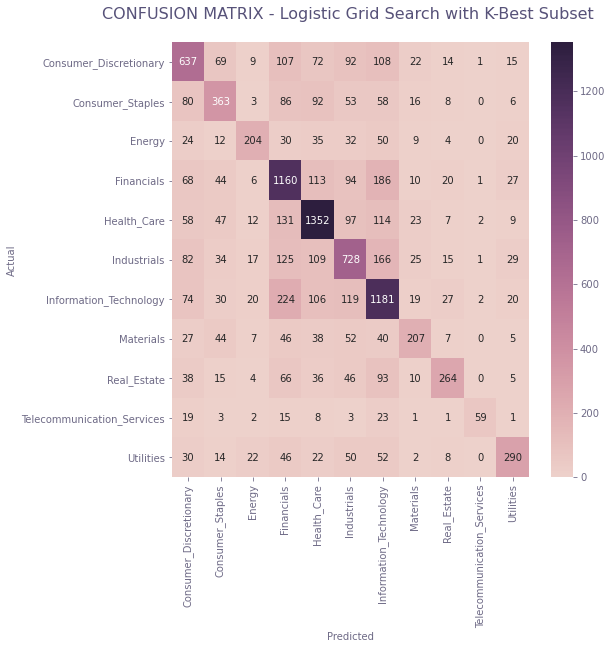

In [78]:
conf_mat = confusion_matrix(y_dev, predictions_sel)

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap=cmap, fmt='d',
            xticklabels=names_sectors, 
            yticklabels=names_sectors)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Logistic Grid Search with K-Best Subset \n", size=16);

### (5) THIRD OPTIMIZATION: Change of model

After having tried to perform some K-Best selection and Dimensionality Reduction, we have found out that they actually don't add much to our model. They do not tend to select less regressors or diminish our features radically. Instead, it seems that our features have a lot of explanatory power in our model, and both K best and Dimensionality Reduction tend to keep all of them.

We have decided to use the iron fist, having tried a bunch of classifiers such as Multinomial Naive Bayes and SVM (that we don't include here for clarity). What was left was Gradient Boosting, well known for its performances but extremely known for its terrible time performance. IT WORKS, IT MARGINALLY INCREASES PERFORMANCE QUITE A LOT, but it takes about 1 hour (A GOOD REASON TO AVOID RUNNING THIS NOTEBOOK). The starting-point parameters have been decided after a number of runs. 

In [79]:
target2 = 'body_style_cat' # CHANGE THE TARGET WHEN NEEDED

y_train_boo = train[target2] # TRAIN y

y_dev_boo = dev[target2] # DEVELOPMENT y

y_test_boo = test[target2] # TEST y

In [80]:
boost = XGBClassifier(use_label_encoder=False, objective='multi:softprob', learning_rate = 0.04,n_estimators = 800, max_depth = 5, subsample = 0.9) 

boost.fit(X_train, y_train_boo)

predictions_boost = boost.predict(X_dev)

print(classification_report(y_dev_boo, predictions_boost))

[12:21:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.61      0.62      0.62      1146
           1       0.66      0.45      0.53       765
           2       0.81      0.45      0.57       420
           3       0.58      0.72      0.64      1729
           4       0.70      0.76      0.73      1852
           5       0.57      0.56      0.57      1331
           6       0.57      0.72      0.63      1822
           7       0.78      0.44      0.56       473
           8       0.93      0.51      0.66       577
           9       0.99      0.55      0.70       135
          10       0.74      0.61      0.66       536

    accuracy                           

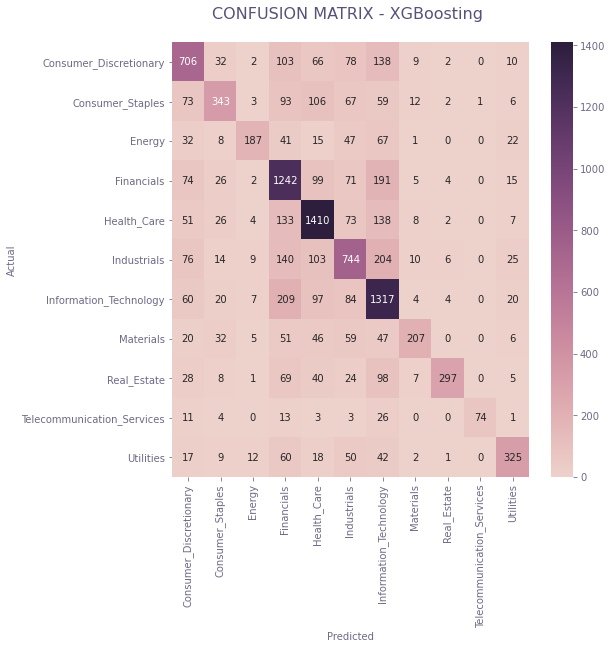

In [81]:
conf_mat = confusion_matrix(y_dev_boo, predictions_boost)

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, 
            cmap=cmap, fmt='d',
            xticklabels=names_sectors,
            yticklabels=names_sectors)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - XGBoosting \n", size=16);

In [82]:
# Since the XGBoost labels are numbers, and we want to compare performance with predictions written as a text, we have to translate the predicted array back!

transdict = {0: 'Consumer_Discretionary',
            1:'Consumer_Staples',
            2: 'Energy',
            3:'Financials',
            4: 'Health_Care',
            5: 'Industrials',
            6:'Information_Technology',
            7:'Materials',
            8:'Real_Estate',
            9:'Telecommunication_Services',
            10: 'Utilities'}

predictions_boost_letters = [transdict[numb] for numb in predictions_boost]

### (6) Bootstrap sampling significance tests

In [83]:
def bootstrap_sample(system1, system2, gold, samples=1000, score=f1_score, average='micro'):
    """
    compute the proportion of times the performance difference of the 
    two systems on a subsample is significantly different from the 
    performance on the entire sample
    """
    N = len(gold) # number of instances
    
    # make sure the two systems have the same number of samples
    assert len(system1) == N and len(system2) == N, 'samples have different lengths'

    # compute performance score on entire sample
    base_score1 = score(gold, system1, average=average)
    base_score2 = score(gold, system2, average=average)
    print("Base difference: {} vs. {}".format(base_score1, base_score2))

    # switch systems if system2 is better
    if base_score2 > base_score1:
        system1, system2 = system2, system1
        base_score1, base_score2 = base_score2, base_score1
    
    # compute the difference
    basedelta = base_score1 - base_score2
    assert basedelta > 0, 'Wrong system first, system1 needs to be better!'

    system1 = np.array(system1)
    system2 = np.array(system2)
    gold = np.array(gold)

    p = 0
    deltas = []
    for i in range(samples):
        # select a subsample, with replacement
        sample = np.random.choice(N, size=N, replace=True)

        # collect data corresponding to subsample
        sample1 = system1[sample]
        sample2 = system2[sample]
        gold_sample = gold[sample]

        # compute scores on subsample
        sample_score1 = score(gold_sample, sample1, average=average)
        sample_score2 = score(gold_sample, sample2, average=average)
        sample_delta = sample_score1 - sample_score2

        # check whether the observed sample difference is at least 
        # twice as large as the base difference
        if sample_delta > 2*basedelta:
            p += 1
        deltas.append(sample_delta)
                
    return p/samples, deltas

In [84]:
# Performance of best model (XGBOOST) against Majority Baseline

p_value1, deltas1 = bootstrap_sample(predictions_boost_letters, dumb_predictions, y_dev)

print(p_value1, p_value1 < 0.01)

Base difference: 0.6352679399221213 vs. 0.17170406081958095
0.0 True


Text(0, 0.5, 'Frequency')

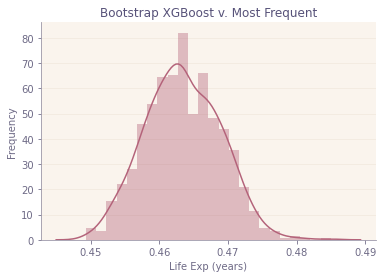

In [85]:
%matplotlib inline

sns.distplot(pd.Series(deltas1))
plt.title('Bootstrap XGBoost v. Most Frequent')
plt.xlabel('Life Exp (years)')
plt.ylabel('Frequency')

In [86]:
# Performance of best model (XGBOOST) against Logistic Baseline

p_value, deltas = bootstrap_sample(predictions_boost_letters, predictions, y_dev)

print(p_value, p_value < 0.01)

Base difference: 0.6352679399221213 vs. 0.5679584646764324
0.0 True


Text(0, 0.5, 'Frequency')

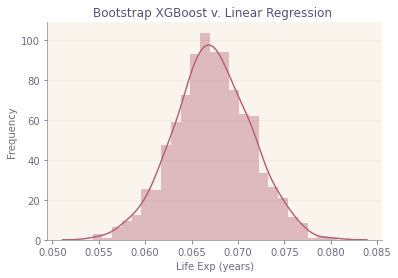

In [87]:
%matplotlib inline

sns.distplot(pd.Series(deltas))
plt.title('Bootstrap XGBoost v. Linear Regression ')
plt.xlabel('Life Exp (years)')
plt.ylabel('Frequency')

### 4.2 Structured Prediction (8pts)
Adapt the Structured Perceptron to your sequence prediction task, and note the performance as baseline (3 pt).
Implement a suitable neural net architecture (in `keras`) on the data (4 pts). Compare the best performance of the  models (1 pt).

In this section, we will implement the structured prediction for which we have decided to manually label more than 2000 linkedin posts, collecting the relevant words for each post under one of these six categories: Diversity&Inclusion, Environment, Financials, Innovation, Social Impact and Other. Clearly, all the non labelled words which have not been considered relevant for our task, have value '0'.

We will implement the Structured Perceptron as baseline and both LSTM and BI-LSTM as neural networks.

In [87]:
df = pd.read_excel('../data/Manual_Annotation.xlsx')
df.loc[df['Tokens'] == 'OOO', 'Tags'] = "OOO"

a = np.array(df['Tokens']).astype(str) # First list with all the tokens we had
b = np.array(df['Tags']).astype(str) # Second list with the associated tags we labelled

sent_list = []
tag_list = []
i=0
while i<len(a):
    sent = []
    tags = []

    while a[i]!='OOO':
        #print(a[i])
        if a[i]!='nan':
            sent.append(a[i])
            tags.append(b[i])
        if i+1<len(a):
            i+=1
        else:
            break
    i+=1
    sent_list.append(sent)
    tag_list.append(tags)
    
c = list(zip(sent_list, tag_list)) # Sentence list and tag list are zipped
c = pd.DataFrame(c).sample(frac=1) # We re-shuffle once again the SENTENCES (of course, not the tokens)
c = list(zip(np.array(c[0]), np.array(c[1])))

train_list = c[:int(len(c)*0.8)]
train_perc = train_list[:int(len(train_list)*0.8)]
dev_perc = train_list[int(len(train_list)*0.8):]
test_list = c[int(len(c)*0.8):]

In [88]:
# Give it a cleaning run before starting once again the perceptron

users = re.compile('@[^ ]+')
numbers = re.compile('[0-9]')
urls = re.compile("(https?:\/\/)?(?:www\.|(?!www))?[^\s\.]+\.[^\s]{2,}|(www)?\.[^\s]+\.[^\s]{2,}")

In [89]:
class StructuredPerceptron(object):

    # Initialize the parameters
    def __init__(self):
        self.tags = set()
        self.feature_weights = defaultdict(lambda: defaultdict(float))
        self.weight_totals = defaultdict(lambda: defaultdict(float))
        self.timestamps = defaultdict(lambda: defaultdict(float))

        self.tag_dict = defaultdict(set)

        self.START = "__START__"
        self.END = "__END__"
        
    # Replace numbers and urls and lowercase the whole sentence
    def normalize(self, word):
        """
        lowercase word, and replace numbers, user names, and URLs
        """
        return re.sub(urls, 'URL', re.sub(numbers, '0', word.strip().lower()))

    
    def evaluate(self, data_instances):
        correct = 0
        total = 0
        for (words, tags) in data_instances:
            preds = self.predict(words)
            matches = sum(map(lambda x: int(x[0]==x[1]), zip(preds, tags)))
            correct += matches
            total += len(tags)
        return correct/total
        
    # Fit the parameters
    def fit(self, tokens, dev_file=None, iterations=10, learning_rate=0.25, inference='greedy', verbose=False):
       
        # initialize tag dictionary for each word and get tag set
        instances = tokens
        for (words, tags) in instances:
            self.tags.update(set(tags))

            for word, tag in zip(words, tags):
                self.tag_dict[self.normalize(word)].add(tag)
        
        if dev_file:
            dev_instances = dev_file
            
        # iterate over data
        for iteration in range(1, iterations+1):
            correct = 0
            total = 0
            if verbose:
                print('Iteration {}'.format(iteration+1), file=sys.stderr, flush=True)
                print("*" * 15, file=sys.stderr, flush=True)

            random.shuffle(instances)
            for i, (words, tags) in enumerate(instances):
                if i > 0:
                    if i%1000==0:
                        print('%s'%i, file=sys.stderr, flush=True)
                    elif i%20==0:
                        print('.', file=sys.stderr, flush=True, end='')

                # get prediction
                prediction = self.predict(words)

                # derive global features
                global_gold_features, global_prediction_features = self.get_global_features(words, prediction, tags)
                                    
                # update weight vector:
                # 1. move closer to true tag
                for tag, fids in global_gold_features.items():
                    for fid, count in fids.items():
                        nr_iters_at_this_weight = iteration - self.timestamps[fid][tag]
                        self.weight_totals[fid][tag] += nr_iters_at_this_weight * self.feature_weights[fid][tag]
                        self.timestamps[fid][tag] = iteration
                        self.feature_weights[fid][tag] += learning_rate * count

                # 2. move further from wrong tag
                for tag, fids in global_prediction_features.items():
                    for fid, count in fids.items():
                        nr_iters_at_this_weight = iteration - self.timestamps[fid][tag]
                        self.weight_totals[fid][tag] += nr_iters_at_this_weight * self.feature_weights[fid][tag]
                        self.timestamps[fid][tag] = iteration
                        self.feature_weights[fid][tag] -= learning_rate * count
                        
                # compute training accuracy for this iteration
                correct += sum([int(predicted_tag == true_tag) for predicted_tag, true_tag in zip(prediction, tags)])
                total += len(tags)

                # output examples
                if verbose and i%1000==0:
                    print("current word accuracy:{:.2f}".format(correct/total))
                    print(list(zip(words, 
                                   [self.normalize(word) for word in words], 
                                   tags, 
                                   prediction)), file=sys.stderr, flush=True)
            
            print('\t{} features'.format(len(self.feature_weights)), file=sys.stderr, flush=True)
            print('\tTraining accuracy: {:.2f}\n'.format(correct/total), file=sys.stderr, flush=True)
            if dev_file:
                print('\tDevelopment accuracy: {:.2f}\n'.format(self.evaluate(dev_instances)), file=sys.stderr, flush=True)
         
        # average weights
        for feature, tags in self.feature_weights.items():
            for tag in tags:
                total = self.weight_totals[feature][tag]
                total += (iterations - self.timestamps[feature][tag]) * self.feature_weights[feature][tag]
                averaged = round(total / float(iterations), 3)
                self.feature_weights[feature][tag] = averaged


    def get_features(self, word, previous_tag2, previous_tag, words, i):
        
        #get all features that can be derived from the word and previous tags
        
        prefix = word[:3]
        suffix = word[-3:]

        features = {
                    'PREFIX={}'.format(prefix),
                    'SUFFIX={}'.format(suffix),
                    'LEN<=3={}'.format(len(word)<=3),
                    'FIRST_LETTER={}'.format(word[0]),
                    'WORD={}'.format(word),
                    'NORM_WORD={}'.format(words[i]),
                    'PREV_WORD={}'.format(words[i-1]),
                    'PREV_WORD_PREFIX={}'.format(words[i-1][:3]),
                    'PREV_WORD_SUFFIX={}'.format(words[i-1][-3:]),
                    'PREV_WORD+WORD={}+{}'.format(words[i-1], words[i]),
                    'NEXT_WORD={}'.format(words[i+1]),
                    'NEXT_WORD_PREFIX={}'.format(words[i+1][:3]),
                    'NEXT_WORD_SUFFIX={}'.format(words[i+1][-3:]),
                    'WORD+NEXT_WORD={}'.format(word, words[i+1]),
                    'NEXT_2WORDS={}+{}'.format(words[i+1], words[i+2]),
                    'PREV_TAG={}'.format(previous_tag),                 # previous tag
                    'PREV_TAG2={}'.format(previous_tag2),                 # two-previous tag
                    'PREV_TAG_BIGRAM={}+{}'.format(previous_tag2, previous_tag),  # tag bigram
                    'PREV_TAG+WORD={}+{}'.format(previous_tag, word),            # word-tag combination
                    'PREV_TAG+PREFIX={}_{}'.format(previous_tag, prefix),        # prefix and tag
                    'PREV_TAG+SUFFIX={}_{}'.format(previous_tag, suffix),        # suffix and tag
                    'WORD+TAG_BIGRAM={}+{}+{}'.format(word, previous_tag2, previous_tag),
                    'SUFFIX+2TAGS={}+{}+{}'.format(suffix, previous_tag2, previous_tag),
                    'PREFIX+2TAGS={}+{}+{}'.format(prefix, previous_tag2, previous_tag),
                    'BIAS'
            }
        return features
    
    
    def get_global_features(self, words, predicted_tags, true_tags):
        
        #sum up local features
        
        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]

        global_gold_features = defaultdict(lambda: Counter())
        global_prediction_features = defaultdict(lambda: Counter())

        prev_predicted_tag = self.START
        prev_predicted_tag2 = self.START
        
        for j, (word, predicted_tag, true_tag) in enumerate(zip(words, predicted_tags, true_tags)):
            # get the predicted features. NB: use j+1, since context is longer than words
            prediction_features = self.get_features(word, prev_predicted_tag2, prev_predicted_tag, context, j+1)

            # update feature correlation with true and predicted tag
            global_prediction_features[predicted_tag].update(prediction_features)
            global_gold_features[true_tag].update(prediction_features)

            prev_predicted_tag2 = prev_predicted_tag
            prev_predicted_tag = predicted_tag

        return global_gold_features, global_prediction_features
            
    
    def get_scores(self, features):
        
        #predict scores for each tag given features
        
        scores = defaultdict(float)
        
        # add up the scores for each tag
        for feature in features:
            if feature not in self.feature_weights:
                continue
            weights = self.feature_weights[feature]
            for tag, weight in weights.items():
                scores[tag] += weight

        # return tag scores
        if not scores:
            # if there are no scores (e.g., first iteration),
            # simply return the first tag with score 1
            scores[list(self.tags)[0]] = 1
        
        return scores
 

    
    def predict(self, words):
       
        #greedy prediction
        
        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]
                
        prev_predicted_tag = self.START
        prev_predicted_tag2 = self.START

        out = []

        for j, word in enumerate(words):
            # for unambiguous words, just look up the tag
            predicted_tag = list(self.tag_dict[context[j+1]])[0] if len(self.tag_dict[context[j+1]]) == 1 else None

            if not predicted_tag:
                # get the predicted features. NB: use j+1, since context is longer than words
                prediction_features = self.get_features(word, prev_predicted_tag2, prev_predicted_tag, context, j+1)
                scores = self.get_scores(prediction_features)
                
                # predict the current tag
                predicted_tag = max(scores, key=scores.get)

            prev_predicted_tag2 = prev_predicted_tag
            prev_predicted_tag = predicted_tag

            out.append(predicted_tag)

        return out
        

    def save(self, file_name):
       
        #save model as pickle file
        
        print("saving model...", end=' ', file=sys.stderr)
        with open(file_name, "wb") as model:
            # pickle cannot save default_dictionaries
            # => make copy and turn into regular dictionaries
            save_feature_weights = defaultdict(lambda: defaultdict(float))
            save_feature_weights.update(self.feature_weights)
            save_tag_dict = defaultdict(set)
            save_tag_dict.update(self.tag_dict)

            save_feature_weights.default_factory = None
            save_tag_dict.default_factory = None
            pickle.dump((save_feature_weights, save_tag_dict, self.tags),
                     model, -1)
        print("done", file=sys.stderr)


    def load(self, file_name):
      
       # load model from pickle file
       
        print("loading model...", end=' ', file=sys.stderr)
        with open(file_name, 'rb') as model:
            try:
                parameters = pickle.load(model)
            except IOError:
                msg = ("No such model file.")
                raise MissingCorpusError(msg)

            feature_weights, tag_dict, tags = parameters
            self.tags = tags

            # pickle cannot store defaultdicts, so we need a 2-step process
            # 1. initialize
            self.feature_weights = defaultdict(lambda: defaultdict(float))
            self.tag_dict = defaultdict(set)
            
            # 2. update
            self.feature_weights.update(feature_weights)
            self.tag_dict.update(tag_dict)
        print("done", file=sys.stderr)
        return None

In [90]:
sp = StructuredPerceptron()
%time sp.fit(train_perc, dev_file=dev_perc, iterations=10)
sp.save('model_greedy.pickle')

.................................................1000
.............	195028 features
	Training accuracy: 0.89

	Development accuracy: 0.68

.................................................1000
.............	205842 features
	Training accuracy: 0.91

	Development accuracy: 0.91

.................................................1000
.............	212729 features
	Training accuracy: 0.92

	Development accuracy: 0.87

.................................................1000
.............	217746 features
	Training accuracy: 0.93

	Development accuracy: 0.91

.................................................1000
.............	221235 features
	Training accuracy: 0.93

	Development accuracy: 0.89

.................................................1000
.............	223786 features
	Training accuracy: 0.94

	Development accuracy: 0.88

.................................................1000
.............	225647 features
	Training accuracy: 0.95

	Development accuracy: 0.90

...........................

Wall time: 1min 58s


saving model... done


Now, we can evaluate the test dataset to find the accuracy of the model

In [91]:
sp.evaluate(test_list)

0.9151103565365025

In [92]:
strange_sentences = ["Managing Director Jeffrey knew existing automation and mechanical design can recycle water for more efficient use. His team used specially slanted roofs at 3M's Customer Technical Center in Taiwan to save 660 tons of rainwater.".split(),
                     "Built for safety. Tesla vehicles combine powerful onboard technology with an all-electric design to help protect every driver, passenger and pedestrian on the road.".split(),
                     '"BlackRock stands in solidarity with our colleagues of Asian descent and their families during this difficult time and stands firmly against such hatred." Larry Fink, our Chairman and CEO, responds to the recent violent attacks against Asian Americans.'.split(),
                     'Hydrogen’s potential for storing and transporting energy from wind and other renewable sources, makes it a key enabler of a global transition to clean energy and Cummins Inc. is excited to be at the forefront. Take a look at three Cummins installations that use wind energy to generate green hydrogen.'.split()
            
                    ]

for i in strange_sentences:
    print(i)
    print(sp.predict(i))

['Managing', 'Director', 'Jeffrey', 'knew', 'existing', 'automation', 'and', 'mechanical', 'design', 'can', 'recycle', 'water', 'for', 'more', 'efficient', 'use.', 'His', 'team', 'used', 'specially', 'slanted', 'roofs', 'at', "3M's", 'Customer', 'Technical', 'Center', 'in', 'Taiwan', 'to', 'save', '660', 'tons', 'of', 'rainwater.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['Built', 'for', 'safety.', 'Tesla', 'vehicles', 'combine', 'powerful', 'onboard', 'technology', 'with', 'an', 'all-electric', 'design', 'to', 'help', 'protect', 'every', 'driver,', 'passenger', 'and', 'pedestrian', 'on', 'the', 'road.']
['O', 'O', 'O', 'O', 'Innovation', 'O', 'O', 'Social_Impact', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['"BlackRock', 'stands', 'in', 'solidarity', 'with', 'our', 'colleagues', 'of', 'Asian', 'descent', 'and', 'th

In this case, we have implemented a Structured Perceptron with a 'greedy' inference method for our scope. Moreover, we have tried to predict 4 completely new LinkedIn posts to see the differences between the three algorithms that we apply.

As we can see, the results are quite impressive in that our model is able to find the general topics for the sentences above by tagging the most relevant words (solidarity - Diversity&Inclusion).

## LSTM 

Once we've got our baseline, we are going to create and implement two neural networks, the LSTM and the BI-LSTM.

In [93]:
def convert2ints(instances, word2int, tag2int):
    result = []
    for (words, tags) in instances:
        # replace words with int, 1 for unknown words
        word_ints = [word2int.get(word, 1) for word in words]
        # replace tags with int
        tag_ints = [tag2int[tag] for tag in tags]
        result.append((word_ints, tag_ints))
    return result  

In [94]:
import numpy as np
np.set_printoptions(precision=2)
nlp = spacy.load('en_core_web_sm')


def LSTM_model (train_list, test_list):
    wordset, tagset = set(), set()
    train_instances = [(words, tags) for (words, tags) in train_list]
    for (words, tags) in train_instances:
        tagset.update(set(tags))
        wordset.update(set(words))

    # map words and tags into ints
    PAD = '-PAD-'
    UNK = '-UNK-'
    word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
    word2int[PAD] = 0  # special token for padding
    word2int[UNK] = 1  # special token for unknown words

    tag2int = {tag: i + 1 for i, tag in enumerate(sorted(tagset))}
    tag2int[PAD] = 0
    # to translate it back
    int2tag = {i:tag for tag, i in tag2int.items()}
    
    # get some test data
    test_instances = [(words, tags) for (words, tags) in test_list]

    # apply integer mapping
    train_instances_int = convert2ints(train_instances, word2int, tag2int)
    test_instances_int = convert2ints(test_instances, word2int, tag2int)

    # separate the words from the tags
    train_sentences, train_tags = zip(*train_instances_int) 
    test_sentences, test_tags = zip(*test_instances_int) 
    
    # get longest training sentence and add 5
    MAX_LENGTH = len(max(train_sentences, key=len)) + 5
    
    # add special padding at the end of every instance, up to MAX_LENGTH
    train_sentences = pad_sequences(train_sentences, maxlen=MAX_LENGTH, padding='post')
    test_sentences = pad_sequences(test_sentences, maxlen=MAX_LENGTH, padding='post')
    train_tags = pad_sequences(train_tags, maxlen=MAX_LENGTH, padding='post')
    test_tags = pad_sequences(test_tags, maxlen=MAX_LENGTH, padding='post')
    
    # Set a random seed for reproducibility
    np.random.seed(42)

    inputs = Input((MAX_LENGTH, ), 
                   name='word_IDs')
    embeddings = Embedding(input_dim=len(word2int), 
                           output_dim=128, 
                           mask_zero=True, 
                           name='embeddings')(inputs)
    lstm = LSTM(units=256,
                  return_sequences=True,
                  name="LSTM")(embeddings)
    dropout = Dropout(0.3, name='dropout')(lstm)
    lstm_out = Dense(len(tag2int), name='output')(dropout)
    output = Activation('softmax', name='softmax')(lstm_out)

    model = Model(inputs=[inputs], outputs=[output])
    model.summary()
    
    train_tags_1hot = to_categorical(train_tags, len(tag2int))
    test_tags_1hot = to_categorical(test_tags, len(tag2int))
    
    # Train the model
    batch_size = 16
    epochs = 10

    # compile the model we have defined above
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']
                 )

    # Run training and capture output log
    history = model.fit(train_sentences, train_tags_1hot,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_split=0.2)
    
    # Plot the Accuracy and the Loss
    df = pd.DataFrame(history.history)
    df[['val_accuracy', 'accuracy']].plot.line();
    df[['val_loss', 'loss']].plot.line();
    
    # Evaluate Accuracy
    loss, accuracy = model.evaluate(test_sentences, test_tags_1hot,
                           batch_size=batch_size, verbose=1)
    print('Test loss:', loss)
    print('Test accuracy:', accuracy)
    
    return model, word2int, tag2int, MAX_LENGTH, int2tag

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_IDs (InputLayer)        [(None, 249)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 249, 128)          1614336   
_________________________________________________________________
LSTM (LSTM)                  (None, 249, 256)          394240    
_________________________________________________________________
dropout (Dropout)            (None, 249, 256)          0         
_________________________________________________________________
output (Dense)               (None, 249, 8)            2056      
_________________________________________________________________
softmax (Activation)         (None, 249, 8)            0         
Total params: 2,010,632
Trainable params: 2,010,632
Non-trainable params: 0
___________________________________________________

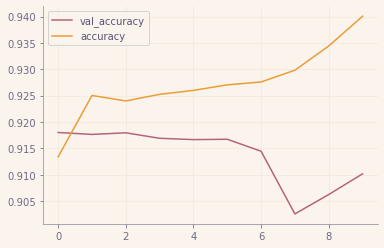

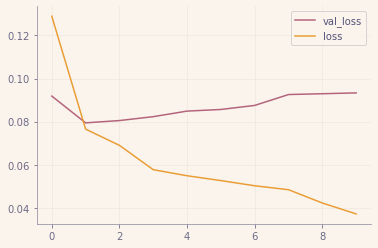

In [95]:
model, word2int, tag2int, MAX_LENGTH, int2tag = LSTM_model(train_list, test_list)

In [96]:
def inverse_transform(sentences, predictions):
    output = []
    for sentence, prediction in zip(sentences, predictions):
        # find the index of the highest-scoring tag and translate it back
        token_sequence = [int2tag[np.argmax(prediction[i])] for i in range(len(sentence))]
        output.append(token_sequence)
    return output

In [97]:

# convert to integers
strange_sentences_int = [[word2int.get(word, 1) for word in sentence] for sentence in strange_sentences]
# add padding
strange_sentences_int = pad_sequences(strange_sentences_int, maxlen=MAX_LENGTH, padding='post')

predictions = model.predict(strange_sentences_int)

print(list(zip(strange_sentences, inverse_transform(strange_sentences, predictions))))

[(['Managing', 'Director', 'Jeffrey', 'knew', 'existing', 'automation', 'and', 'mechanical', 'design', 'can', 'recycle', 'water', 'for', 'more', 'efficient', 'use.', 'His', 'team', 'used', 'specially', 'slanted', 'roofs', 'at', "3M's", 'Customer', 'Technical', 'Center', 'in', 'Taiwan', 'to', 'save', '660', 'tons', 'of', 'rainwater.'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'Innovation', 'Innovation', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['Built', 'for', 'safety.', 'Tesla', 'vehicles', 'combine', 'powerful', 'onboard', 'technology', 'with', 'an', 'all-electric', 'design', 'to', 'help', 'protect', 'every', 'driver,', 'passenger', 'and', 'pedestrian', 'on', 'the', 'road.'], ['O', 'O', 'O', 'O', 'Innovation', 'Innovation', 'Innovation', 'O', 'Innovation', 'O', 'O', 'O', 'Innovation', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['"BlackRock', 'stands', 'in', 'solidarity', 'with', 'our'

As before, even here we get quite significant results as the the model is almost able to detect the main topics, even though sometimes it doesn't hold (recycle - Innovation). However, in general the test accuracy level is a bit better than the Strucured Perceptron.

## BI-LSTM

In [98]:
def BI_LSTM_model (train_list, test_list):
    
    wordset, tagset = set(), set()
    train_instances = [(words, tags) for (words, tags) in train_list]
    for (words, tags) in train_instances:
        tagset.update(set(tags))
        wordset.update(set(words))

    # map words and tags into ints
    PAD = '-PAD-'
    UNK = '-UNK-'
    word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
    word2int[PAD] = 0  # special token for padding
    word2int[UNK] = 1  # special token for unknown words

    tag2int = {tag: i + 1 for i, tag in enumerate(sorted(tagset))}
    tag2int[PAD] = 0
    # to translate it back
    int2tag = {i:tag for tag, i in tag2int.items()}
    
    # get some test data
    test_instances = [(words, tags) for (words, tags) in test_list]

    # apply integer mapping
    train_instances_int = convert2ints(train_instances, word2int, tag2int)
    test_instances_int = convert2ints(test_instances, word2int, tag2int)

    # separate the words from the tags
    train_sentences, train_tags = zip(*train_instances_int) 
    test_sentences, test_tags = zip(*test_instances_int) 
    
    # get longest training sentence and add 5
    MAX_LENGTH = len(max(train_sentences, key=len)) + 5
    
    # add special padding at the end of every instance, up to MAX_LENGTH
    train_sentences = pad_sequences(train_sentences, maxlen=MAX_LENGTH, padding='post')
    test_sentences = pad_sequences(test_sentences, maxlen=MAX_LENGTH, padding='post')
    train_tags = pad_sequences(train_tags, maxlen=MAX_LENGTH, padding='post')
    test_tags = pad_sequences(test_tags, maxlen=MAX_LENGTH, padding='post')
    
    # Set a random seed for reproducibility
    np.random.seed(42)

    inputs = Input((MAX_LENGTH, ), 
                   name='word_IDs')
    embeddings = Embedding(input_dim=len(word2int), 
                           output_dim=128, 
                           mask_zero=True, 
                           name='embeddings')(inputs)
    #wrap the LSTM in a Bidirectional wrapper
    bilstm = Bidirectional(LSTM(units=256, 
                                return_sequences=True), 
                           name="Bi-LSTM")(embeddings)
    dropout = Dropout(0.3, name='dropout')(bilstm)
    bilstm_out = Dense(len(tag2int), name='output')(dropout)
    output = Activation('softmax', name='softmax')(bilstm_out)

    model_bilstm = Model(inputs=[inputs], outputs=[output])
    model_bilstm.summary()
    
    train_tags_1hot = to_categorical(train_tags, len(tag2int))
    test_tags_1hot = to_categorical(test_tags, len(tag2int))
    
    batch_size = 16
    epochs = 10

    model_bilstm.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']
                 )

    history_bilstm = model_bilstm.fit(train_sentences, train_tags_1hot,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_split=0.2)

    df = pd.DataFrame(history_bilstm.history)
    df[['val_accuracy', 'accuracy']].plot.line();
    df[['val_loss', 'loss']].plot.line();
    
    loss, accuracy = model_bilstm.evaluate(test_sentences, test_tags_1hot,
                       batch_size=batch_size, verbose=1)
    print('Test loss:', loss)
    print('Test accuracy:', accuracy)
    
    return model, word2int, tag2int, MAX_LENGTH, int2tag

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_IDs (InputLayer)        [(None, 249)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 249, 128)          1614336   
_________________________________________________________________
Bi-LSTM (Bidirectional)      (None, 249, 512)          788480    
_________________________________________________________________
dropout (Dropout)            (None, 249, 512)          0         
_________________________________________________________________
output (Dense)               (None, 249, 8)            4104      
_________________________________________________________________
softmax (Activation)         (None, 249, 8)            0         
Total params: 2,406,920
Trainable params: 2,406,920
Non-trainable params: 0
_________________________________________________

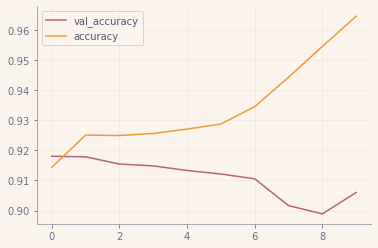

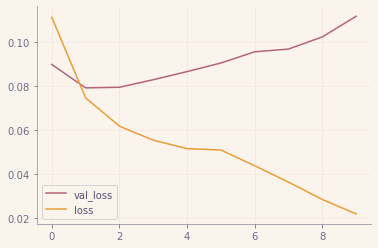

In [99]:
model_bilstm, word2int, tag2int, MAX_LENGTH, int2tag = BI_LSTM_model(train_list, test_list)

In [100]:
predictions_bilstm = model_bilstm.predict(strange_sentences_int)
print(list(zip(strange_sentences, inverse_transform(strange_sentences, predictions_bilstm))))

[(['Managing', 'Director', 'Jeffrey', 'knew', 'existing', 'automation', 'and', 'mechanical', 'design', 'can', 'recycle', 'water', 'for', 'more', 'efficient', 'use.', 'His', 'team', 'used', 'specially', 'slanted', 'roofs', 'at', "3M's", 'Customer', 'Technical', 'Center', 'in', 'Taiwan', 'to', 'save', '660', 'tons', 'of', 'rainwater.'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'Innovation', 'Innovation', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['Built', 'for', 'safety.', 'Tesla', 'vehicles', 'combine', 'powerful', 'onboard', 'technology', 'with', 'an', 'all-electric', 'design', 'to', 'help', 'protect', 'every', 'driver,', 'passenger', 'and', 'pedestrian', 'on', 'the', 'road.'], ['O', 'O', 'O', 'O', 'Innovation', 'Innovation', 'Innovation', 'O', 'Innovation', 'O', 'O', 'O', 'Innovation', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['"BlackRock', 'stands', 'in', 'solidarity', 'with', 'our'

Finally, the BI-LSTM is also able to detect the words that mainly characterize the topic of the post. However, like its counterpart, it does some mistakes.

For what regards the accuracy, it has improved with respect to the Structured Perceptron, but performs worse than the simple LSTM model.

## 3. Visualizations (5 pts)

Provide at least 3 visualizations of your work above. These can be in the respective sections. Use labels and legends. Be creative. Just please do not use word clouds...

As you have previously seen, we already included the visualizations in the respective sections.

We hope our work has been interesting for you as it was for us.

Thank you, 
### Ashar, Rebecca, Tiziano.